In [1]:
import torch

# Check if MPS is available
if torch.backends.mps.is_available():
    print(f"MPS is available. Using GPU.")
else:
    print("MPS is not available. Using CPU.")

MPS is available. Using GPU.


In [17]:
import os
print(os.getcwd())

/Users/saeah/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1


In [2]:
import os

# Set the working directory
working_directory = "/Users/saeah/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1"
os.chdir(working_directory)

In [3]:
!pip install kagglehub pillow opencv-python numpy matplotlib

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("meowmeowmeowmeowmeow/gtsrb-german-traffic-sign")

print("Path to dataset files:", path)

Path to dataset files: /Users/saeah/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1


In [5]:
import os

# Path where the dataset is downloaded
dataset_path = path

# List all files in the directory
files = os.listdir(dataset_path)
print(files)

['.DS_Store', 'Test', 'Test.csv', 'Meta', 'Old', 'Obscured_Train 2.30.00\u202fPM', 'Train', 'Meta.csv', 'Train.csv']


In [6]:
import os
from pathlib import Path

import cv2
import random
import numpy as np
from pathlib import Path
import cv2
import numpy as np
from PIL import Image

Data Augmentation (Define Obscuration Functions)
# Obscuration functions

In [7]:
# Blurring (Gaussianb Blur): Blurring is a classic technique to obscure details in an image.

# # Apply Gaussian Blur - simulating poor visibility conditions (fog, rain, etc.)
# blurred_image = image.filter(ImageFilter.GaussianBlur(radius=5))

def add_blur(image, ksize=5):
    return cv2.GaussianBlur(image, (ksize, ksize), 0)

# simulating sensor noise, poor image quality, or bad weather conditions like snow or rain
def add_noise(image, noise_level=10):
    noisy_image = image + noise_level * np.random.normal(loc=0.0, scale=1.0, size=image.shape)
    return np.clip(noisy_image, 0, 255).astype(np.uint8)

# Whitening: making the image brighter or changing its contrast to obscure the details 
# (Brightness/Contrast Change) - simulates overexposure, glare, or high-intensity lightning conditions
# simulate bright daylight or glare from the sun
# # Apply whitening (simple linear transformation to make image brighter)
def add_whitening(image, noise_level=10):
    # Assuming the input image is a numpy array
    whitened_image = cv2.convertScaleAbs(image, alpha=1.5, beta=50)  # alpha: contrast, beta: brightness
    # Convert the image back to numpy array if it's a PIL image
    if isinstance(whitened_image, Image.Image):
        whitened_image = np.array(whitened_image)
    return whitened_image  
    
# Adding Fog (Simulating a Foggy Image): Fog or blur with added randomness can obscure features in an image
# # Create a random mask to simulate fog
# simulating foggy conditions or poor visibility due to environmental factors
def add_fog(image, intensity=0.5):
    overlay = np.full(image.shape, 255, dtype=np.uint8)
    return cv2.addWeighted(image, 1 - intensity, overlay, intensity, 0)



# Adding a Black Diagonal (Obscuring a section of the image): adding black boxes
# # Add a black diagonal (line from top-left to bottom-right)
# partial occulusion - obscured by objects, which could be other vehicles, pedestrians, or road signs covered by trees
import random
import numpy as np

def add_black_section(image, block_size=10):
    h, w = image.shape[:2]
    
    # # Ensure the block size does not exceed the image dimensions
    # block_size = min(block_size, h, w)
    
    # Choose a region to block randomly
    region = random.choice(['lower_diagonal', 'upper_diagonal', 'bottom', 'top', 'left', 'right'])

    modified_image = image.copy()
    
    if region == 'lower_diagonal':
        # Make the lower triangular part of the image black
        for y in range(h):
            for x in range(w):
                if y > x:  # Below the diagonal
                    modified_image[y, x] = 0

    elif region == 'upper_diagonal':
        # Make the upper triangular part of the image black
        for y in range(h):
            for x in range(w):
                if y < x:  # Above the diagonal
                    modified_image[y, x] = 0

    elif region == 'left':
        # Make the left 30% of the image black
        cutoff = int(w * 0.3)  # 30% of the width
        modified_image[:, :cutoff] = 0

    elif region == 'right':
        # Make the right 30% of the image black
        cutoff = int(w * 0.7)  # Start at 70% of the width
        modified_image[:, cutoff:] = 0

    elif region == 'top':
        # Make the top 30% of the image black
        cutoff = int(h * 0.3)  # 30% of the height
        modified_image[:cutoff, :] = 0

    elif region == 'bottom':
        # Make the bottom 30% of the image black
        cutoff = int(h * 0.7)  # Start at 70% of the height
        modified_image[cutoff:, :] = 0

    return modified_image

# capturing moving objects at high speeds or driving fast can introduce motion blur
def add_motion_blur(image, direction='horizontal', kernel_size=15):
    alpha = 0.2
    # Validate kernel size
    if kernel_size < 1:
        raise ValueError("Kernel size must be greater than 0.")

    # Create the motion blur kernel
    kernel = np.zeros((kernel_size, kernel_size))
    if direction == 'horizontal':
        kernel[int((kernel_size - 1) / 2), :] = np.ones(kernel_size)
    elif direction == 'vertical':
        kernel[:, int((kernel_size - 1) / 2)] = np.ones(kernel_size)
    else:
        raise ValueError("Direction must be 'horizontal' or 'vertical'.")

    # Normalize the kernel
    kernel /= kernel.sum()

    # Apply the kernel to create motion blur
    blurred_image = cv2.filter2D(image, -1, kernel)

    # Blend the blurred image with the original to reduce intensity
    output_image = cv2.addWeighted(image, alpha, blurred_image, 1 - alpha, 0)

    return output_image

    
# parts of signs can be obstructed by objects like other vehicles or environmental factors (e.g., dirt on the lens)
def add_occlusion(image, num_spots=15, spot_size=3):
    modified_image = image.copy()

    h, w, _ = modified_image.shape
    for _ in range(num_spots):
        x = random.randint(0, w - spot_size)
        y = random.randint(0, h - spot_size)
        cv2.rectangle(modified_image, (x, y), (x + spot_size, y + spot_size), (0, 0, 0), -1)
    return modified_image

# low-light/nighttime simulation: images taken during nighttime or in low-light conditions can be harder to analyze
def add_low_light(image, factor=0.3):
    low_light_image = cv2.convertScaleAbs(image, alpha=factor, beta=0)
    return low_light_image

# lens distortion: some cameras introduce barrel or pincushion distortion (wide-angle lenses)
def add_lens_distortion(image, distortion_factor=0.1):
    modified_image = image.copy()
    h, w = modified_image.shape[:2]
    K = np.array([[w / 2, 0, w / 2],
                  [0, h / 2, h / 2],
                  [0, 0, 1]])
    dist = np.array([distortion_factor, distortion_factor, 0, 0])
    return cv2.undistort(modified_image, K, dist)

# light reflections or glare can obscure objects, especially in high-sunlight conditions
def add_glare(image, intensity=0.2):
    h, w, _ = image.shape
    x_center = random.randint(0, w)
    y_center = random.randint(0, h)
    radius = random.randint(30, 100)
    glare = np.zeros_like(image, dtype=np.uint8)
    cv2.circle(glare, (x_center, y_center), radius, (255, 255, 255), -1)
    return cv2.addWeighted(image, 1 - intensity, glare, intensity, 0)

# image compression (artifacts): low-quality images or video feeds can suffer from compression artifacts, which can affect model performance
def add_compression_artifacts(image, quality=10):
    encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), quality]
    _, img_encoded = cv2.imencode('.jpg', image, encode_param)
    return cv2.imdecode(img_encoded, 1)

In [8]:
# Apply Obscuration to images
def apply_obscuration(image, techniques):
    for technique in techniques:
        image = technique(image)
    return image

In [9]:
# Function to calculate the total number of images in the dataset
def get_total_images_in_train(input_dir):
    total_images = 0
    for folder in input_dir.iterdir():
        if folder.is_dir():  # Check for subfolders (class directories)
            total_images += len(list(folder.glob('*.png')))
    return total_images

In [10]:
# Copy original dataset (flatten the structure)
def copy_original_dataset(input_dir, output_dir):
    input_dir = Path(input_dir)
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)

    for folder in input_dir.iterdir():
        if folder.is_dir():  # If it's a subfolder
            for image_path in folder.iterdir():
                if image_path.suffix == '.png':
                    image = cv2.imread(str(image_path))
                    cv2.imwrite(str(output_dir / image_path.name), image)
        elif folder.suffix == '.png':  # If it's an image in the main folder
            image = cv2.imread(str(folder))
            cv2.imwrite(str(output_dir / folder.name), image)

In [11]:
import matplotlib.pyplot as plt
# Function to select and obscure a portion of images from each class
def select_and_obscure(input_dir, output_dir, obscuration_functions, obscuration_steps, percentage, is_train):

    # Get all images, considering different folder structure for train and test
    all_images = []
    
    if is_train:
        # For train folder, iterate over each subfolder and collect images
        for subfolder in Path(input_dir).iterdir():
            if subfolder.is_dir():
                all_images.extend(subfolder.glob('*.png'))  # Add all .png images from the subfolder
    else:
        # For test folder, just collect images from the folder
        all_images = list(Path(input_dir).glob('*.png'))
    
    # Calculate the number of images to obscure based on the percentage
    images_to_obscure = max(1, int(len(all_images) * percentage / 100))  # Ensures at least 1 image is selected
    
    # Loop over each obscuration function
    for step in range(obscuration_steps):
        print(f"Applying obscuration function {step + 1} out of {obscuration_steps}...")

        # Select random images to obscure for the current step
        selected_images = random.sample(all_images, images_to_obscure)


        # Apply the selected obscuration function to the chosen images
        for i, image_path in enumerate(selected_images):
            original_image = cv2.imread(str(image_path))
            
            # Apply the current obscuration function
            obscured_image = obscuration_functions[step](original_image)

            # Display the first image for each obscuration function
            if i < 5:  # Only for the first image
                plt.figure(figsize=(10, 5))  # Set the figure size
                # Left: Original image
                plt.subplot(1, 2, 1)
                plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display
                plt.axis('off')
                plt.title("Original Image")

                # Right: Obscured image
                plt.subplot(1, 2, 2)
                plt.imshow(cv2.cvtColor(obscured_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display
                plt.axis('off')
                plt.title(f"Obscured - {obscuration_functions[step].__name__}")

                # Show the comparison
                plt.tight_layout()
                plt.show()

            # Save the obscured image to the output directory
            output_image_path = Path(output_dir) / image_path.name
            cv2.imwrite(str(output_image_path), obscured_image)

Applying obscuration function 1 out of 11...


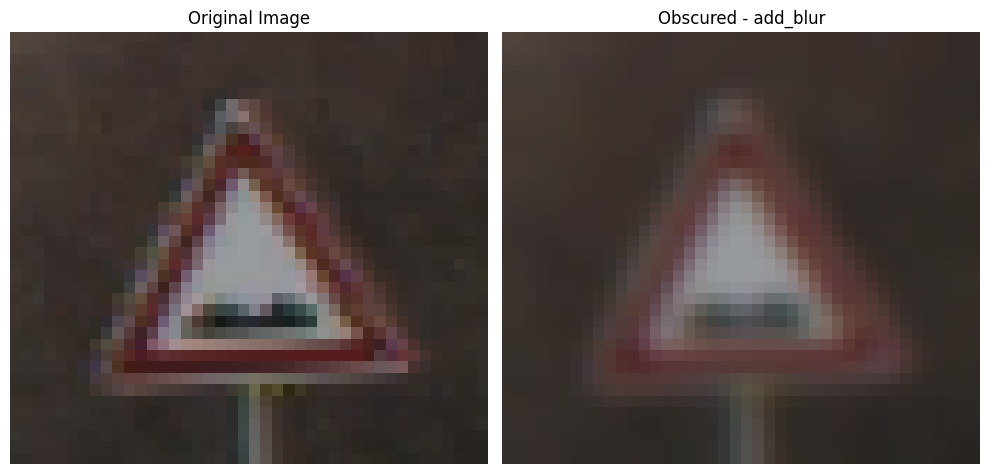

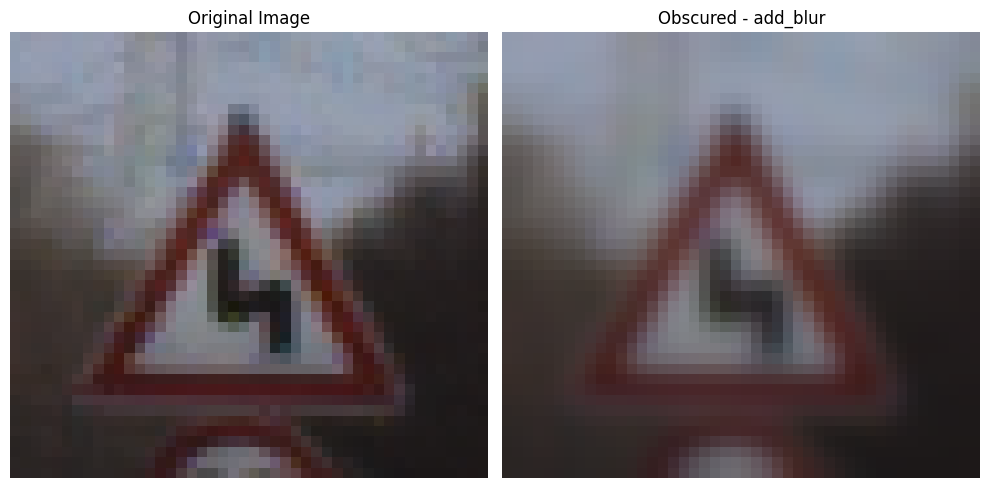

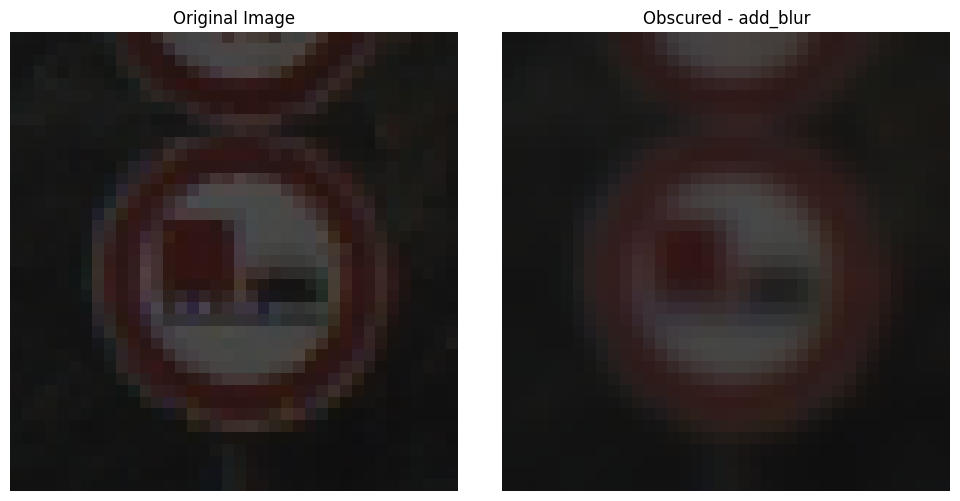

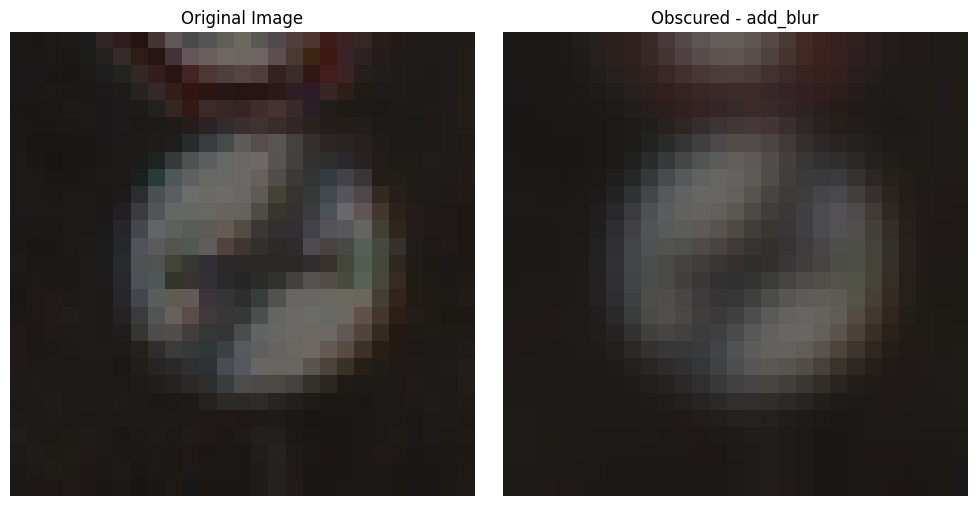

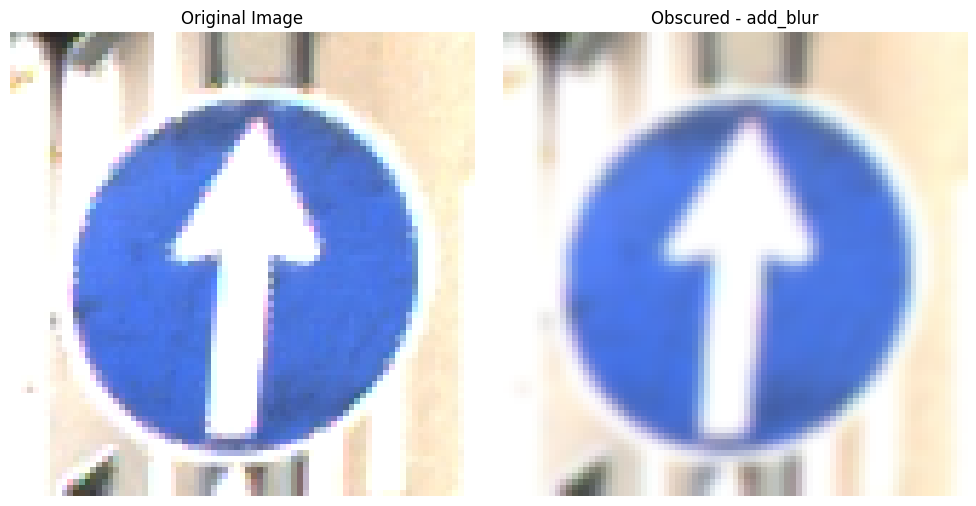

Applying obscuration function 2 out of 11...


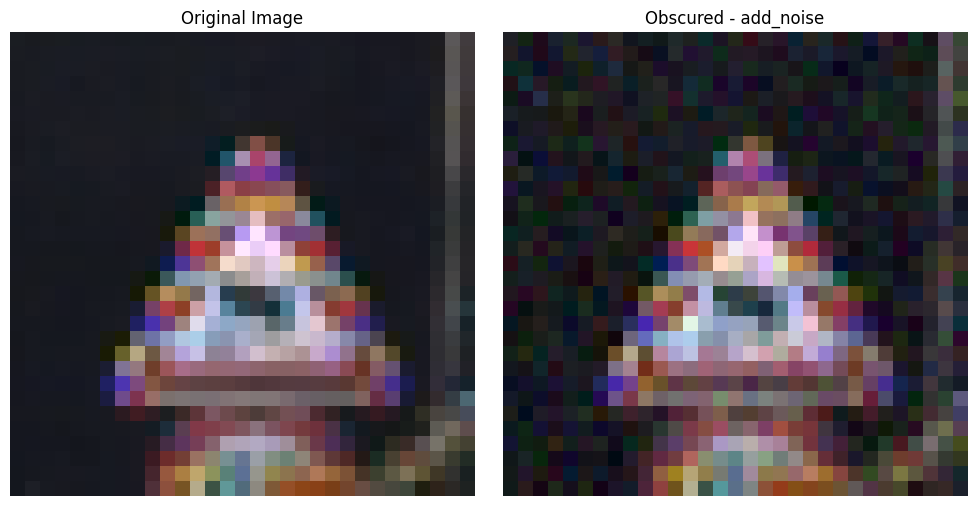

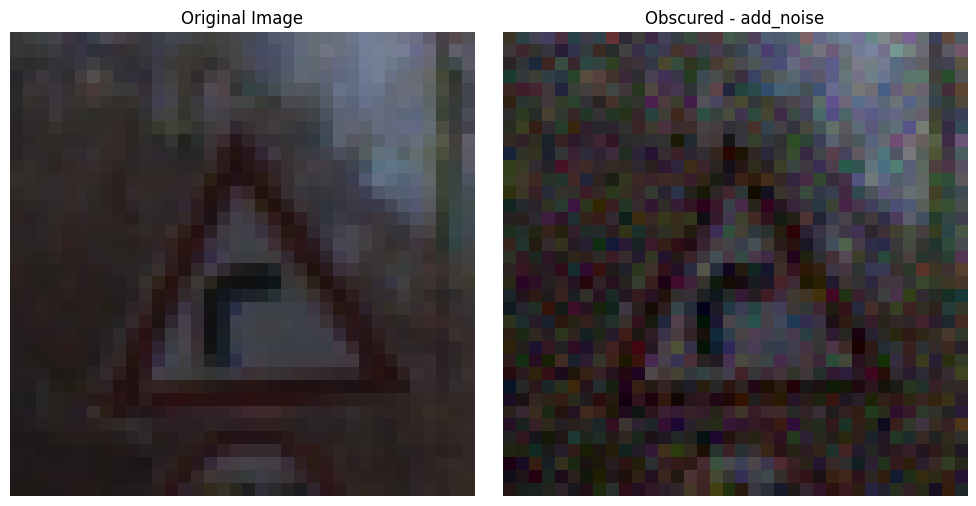

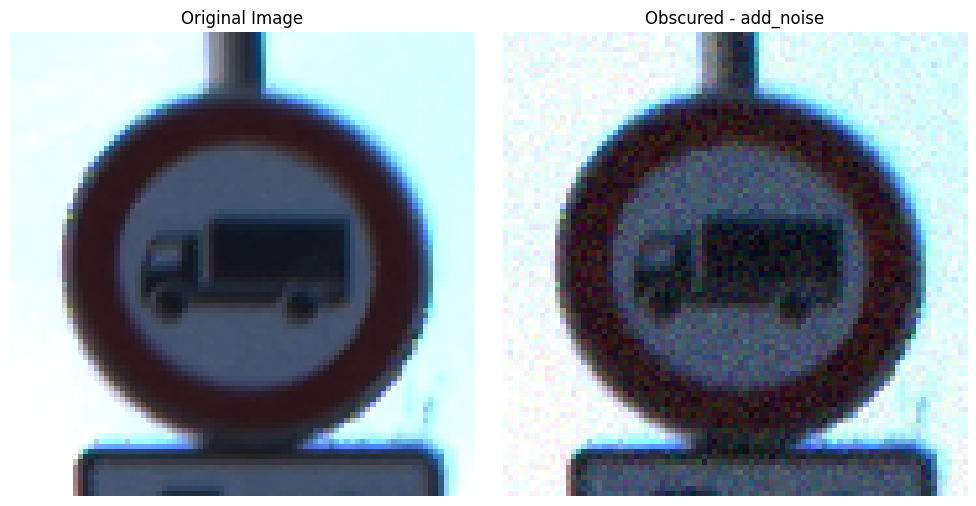

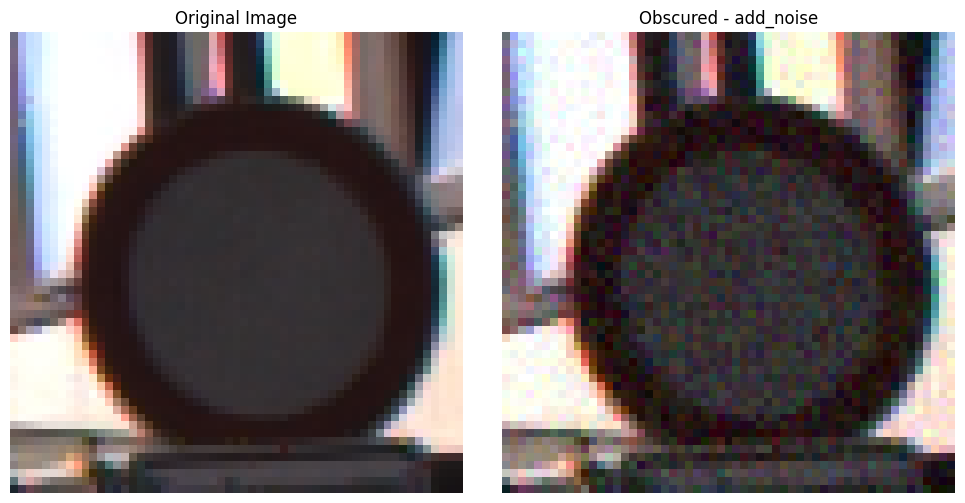

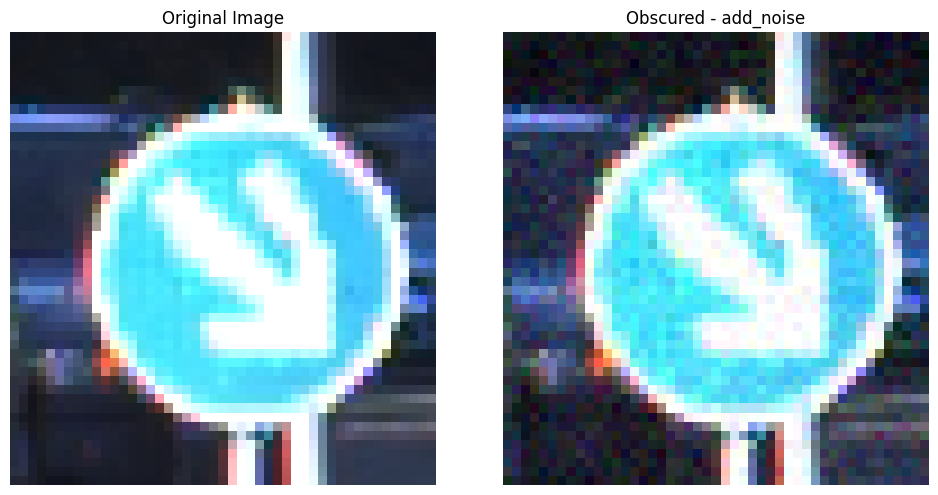

Applying obscuration function 3 out of 11...


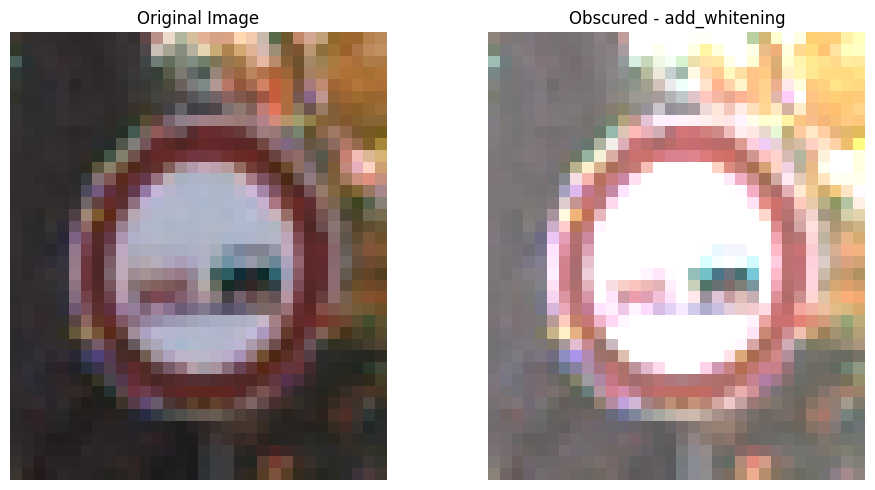

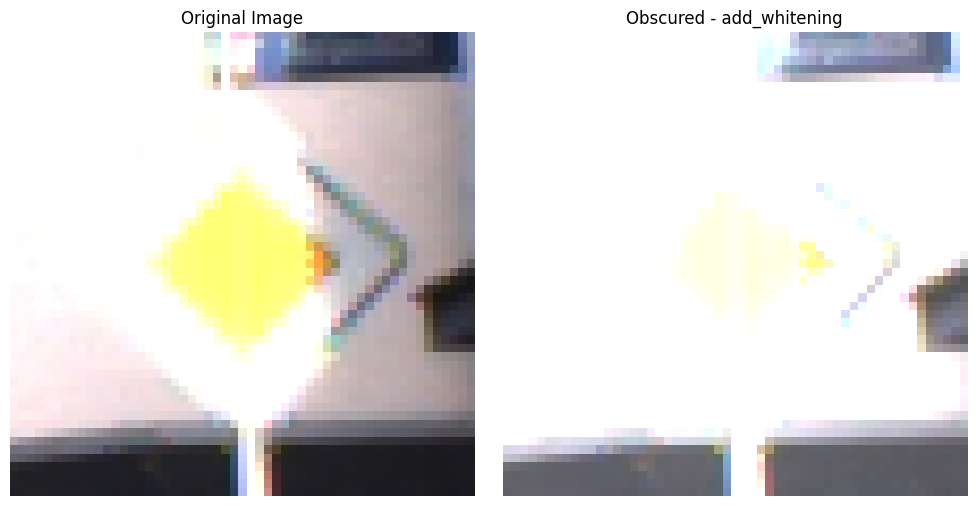

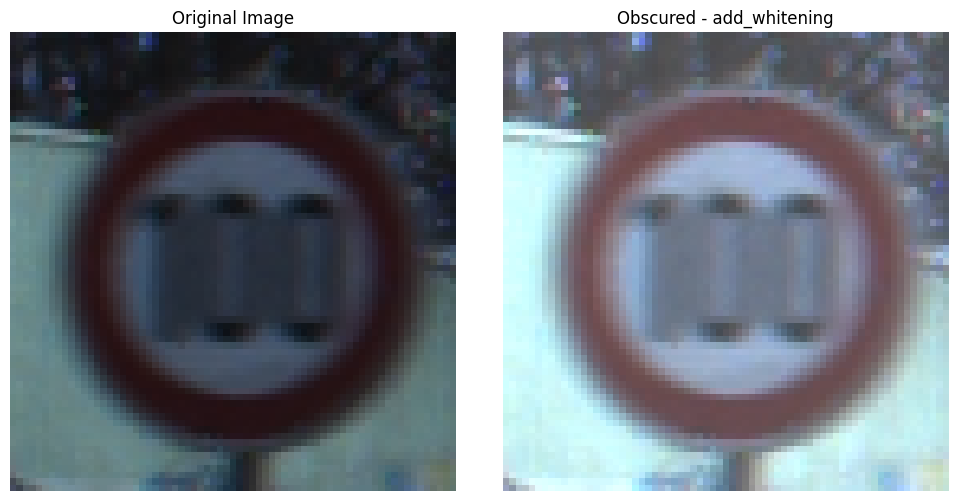

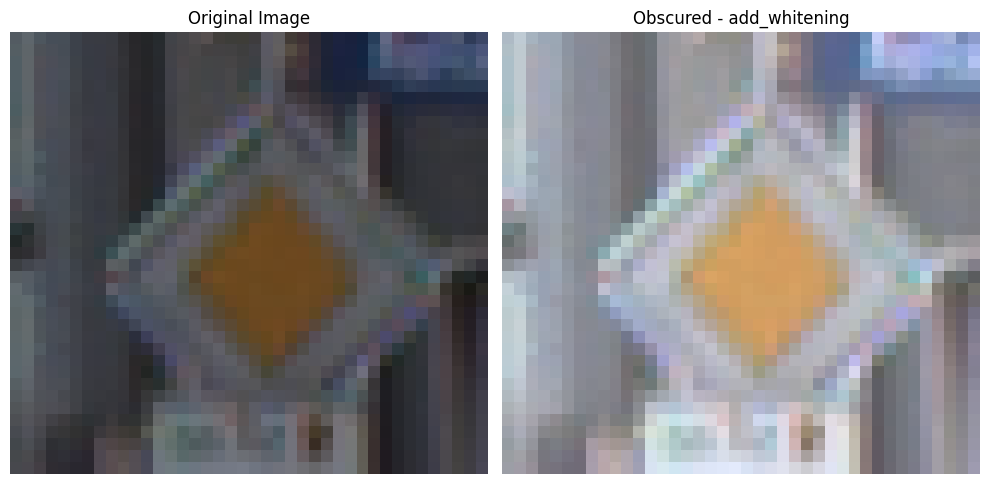

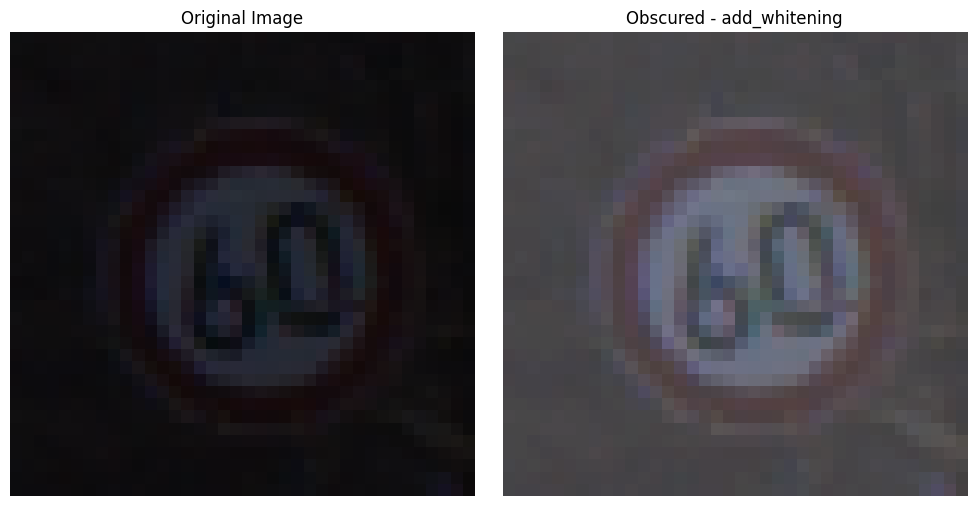

Applying obscuration function 4 out of 11...


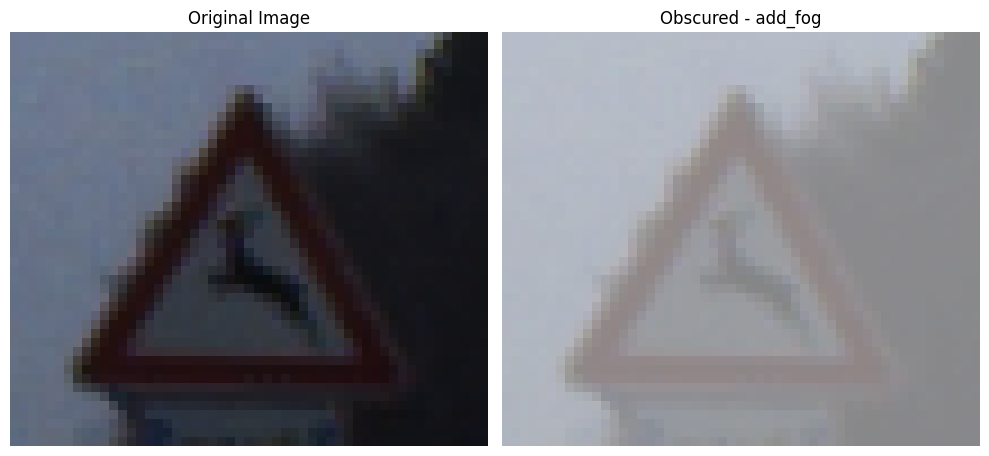

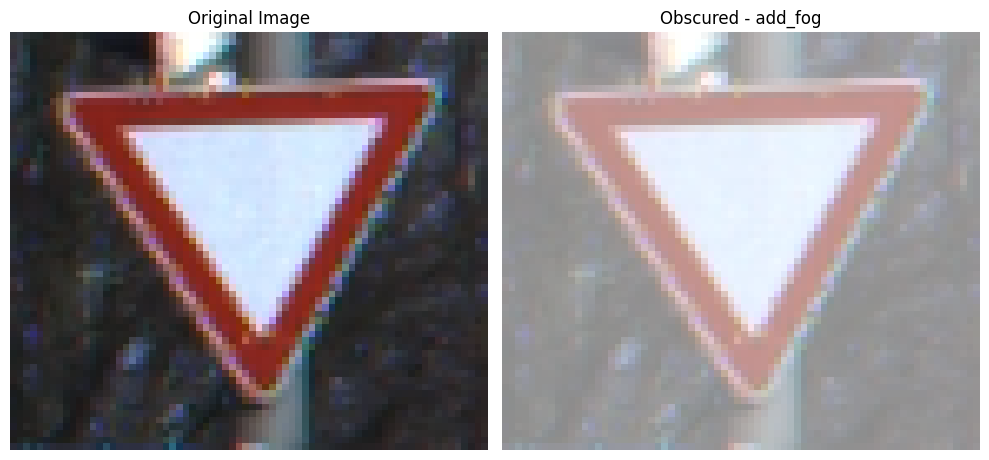

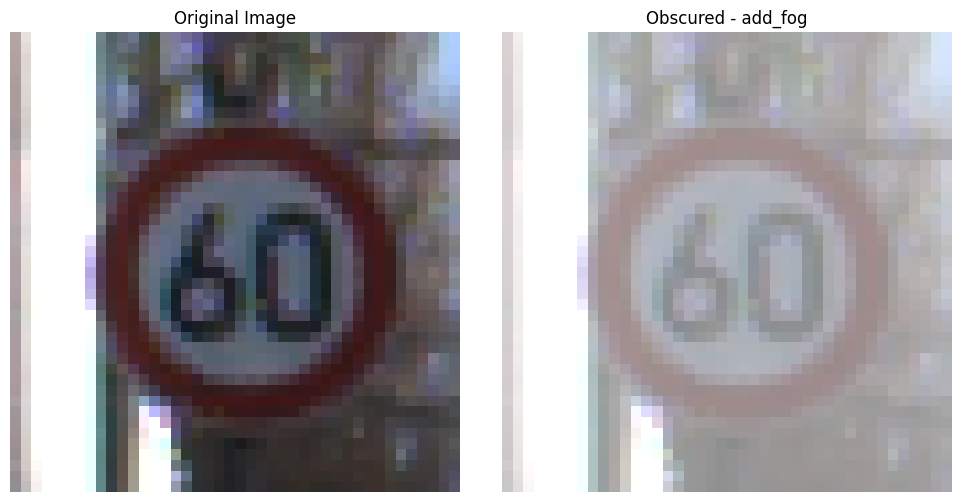

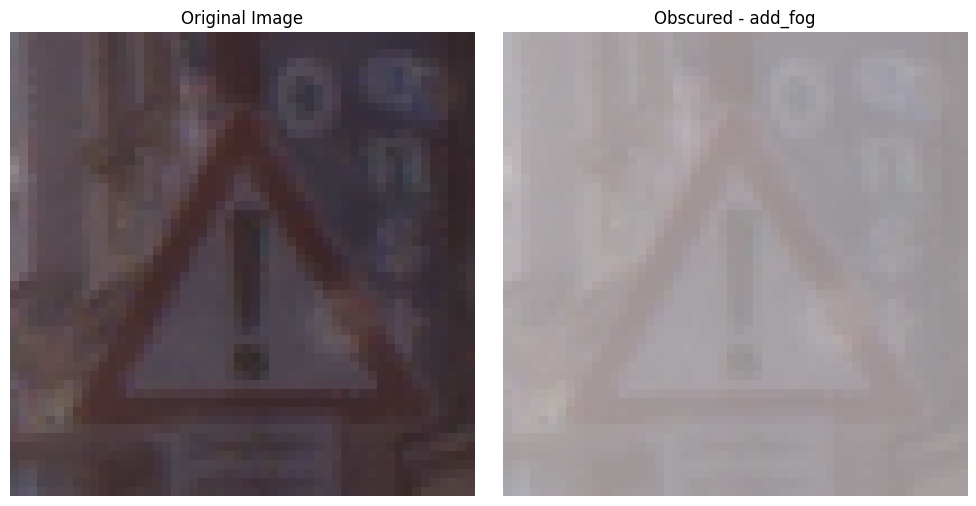

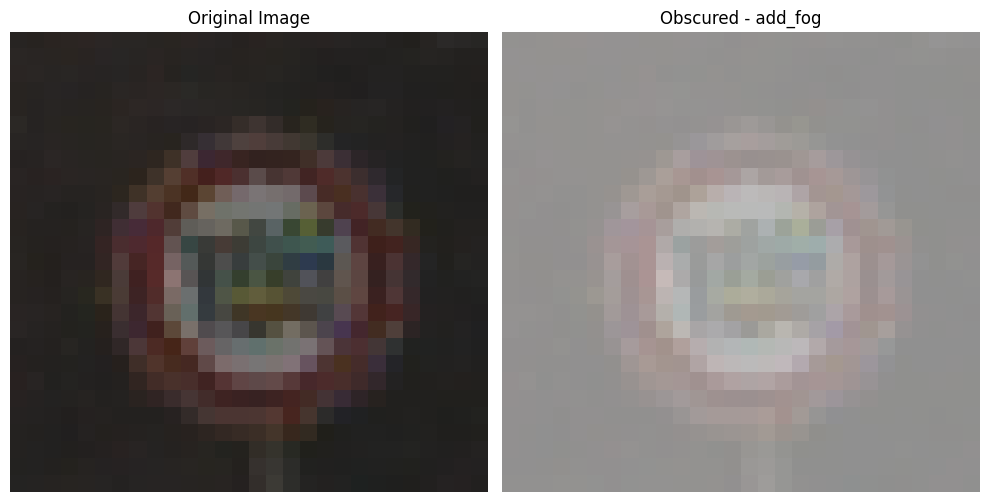

Applying obscuration function 5 out of 11...


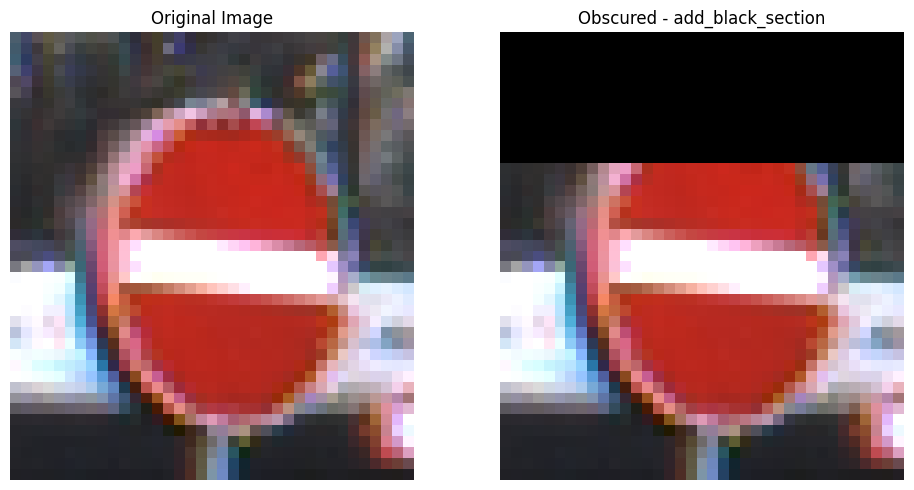

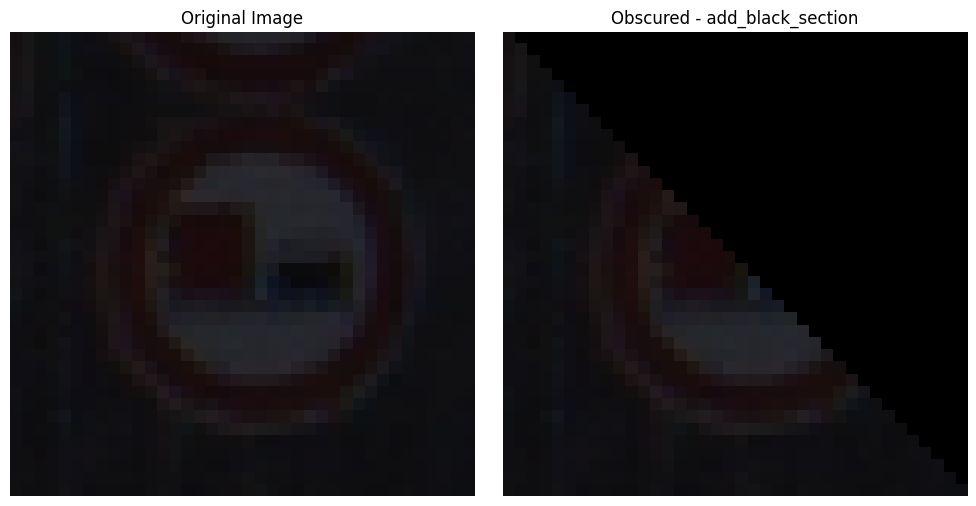

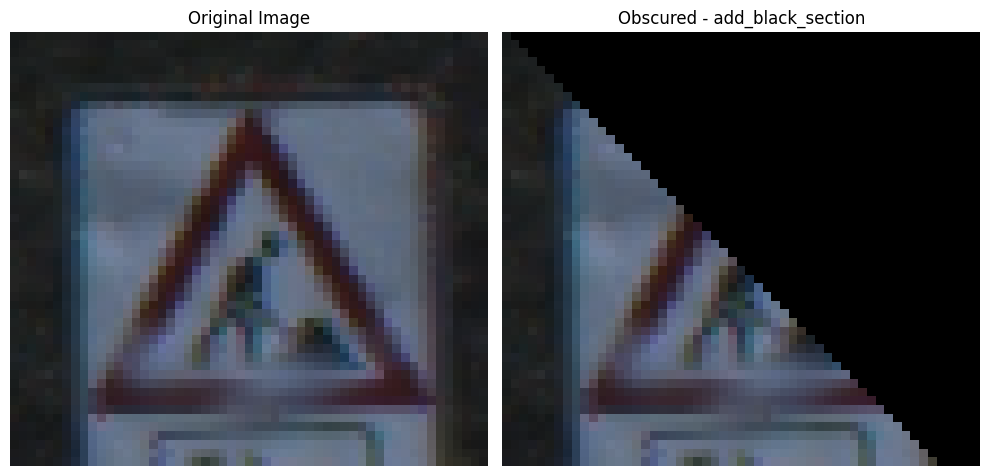

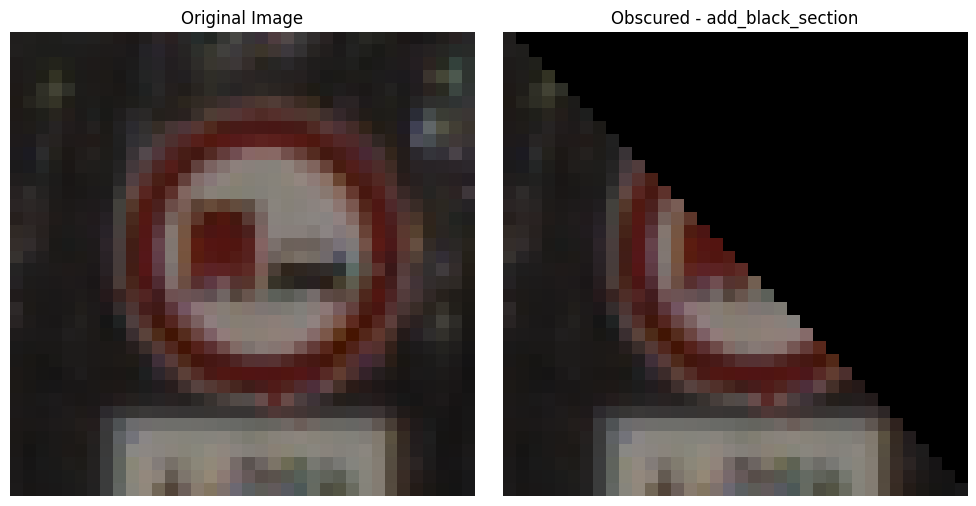

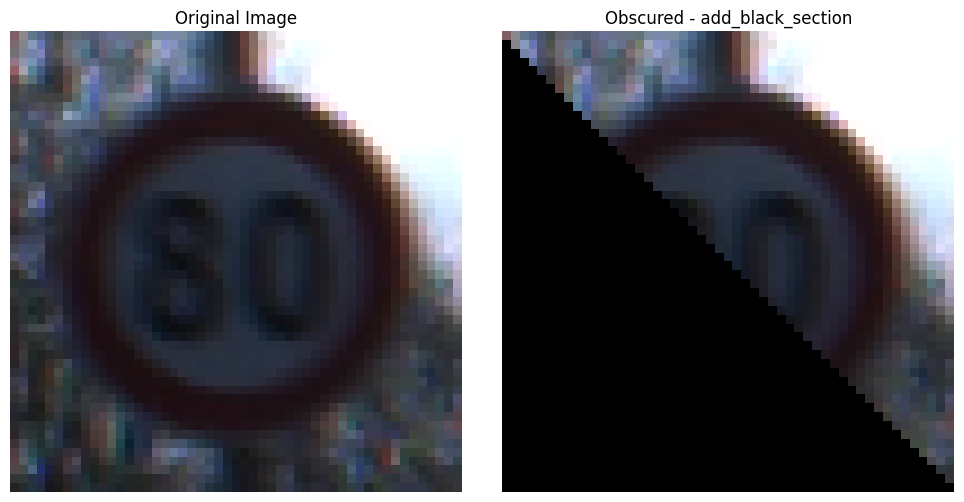

Applying obscuration function 6 out of 11...


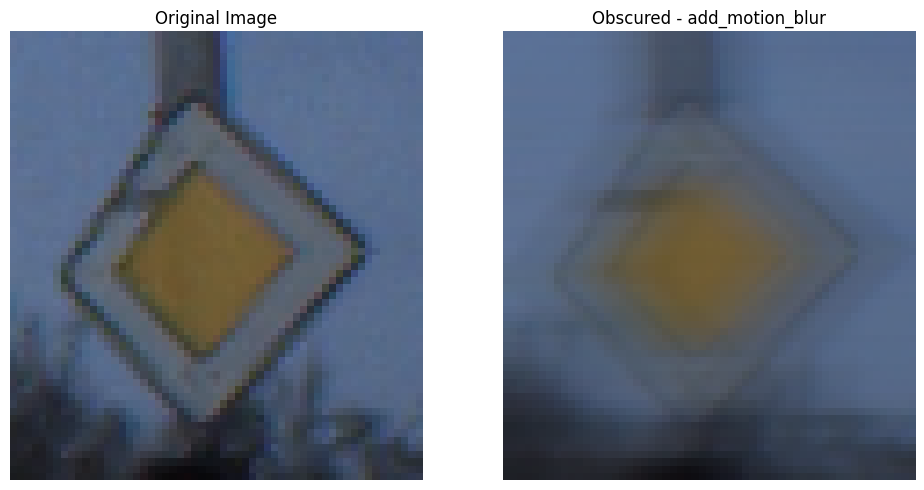

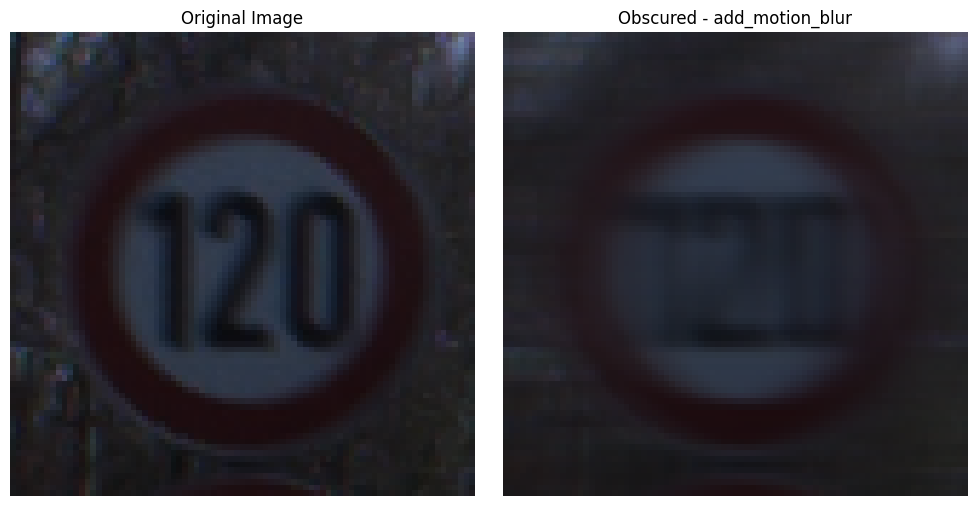

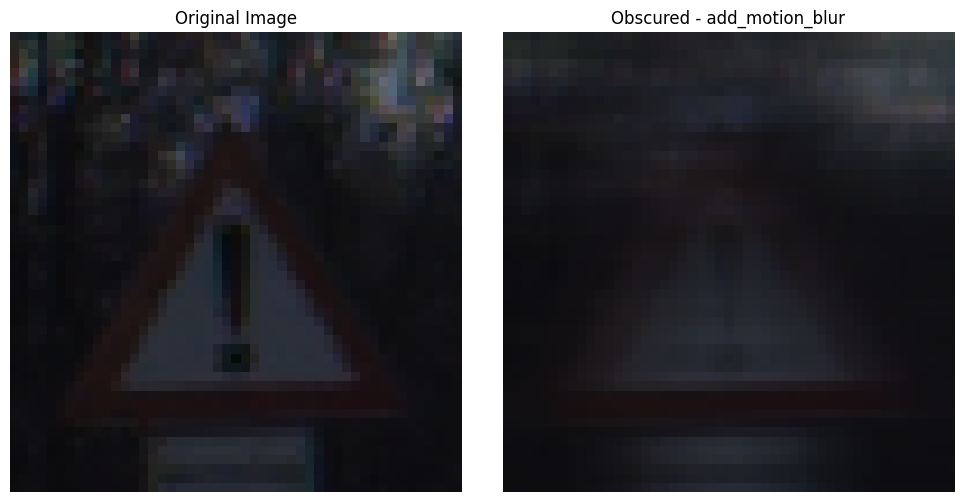

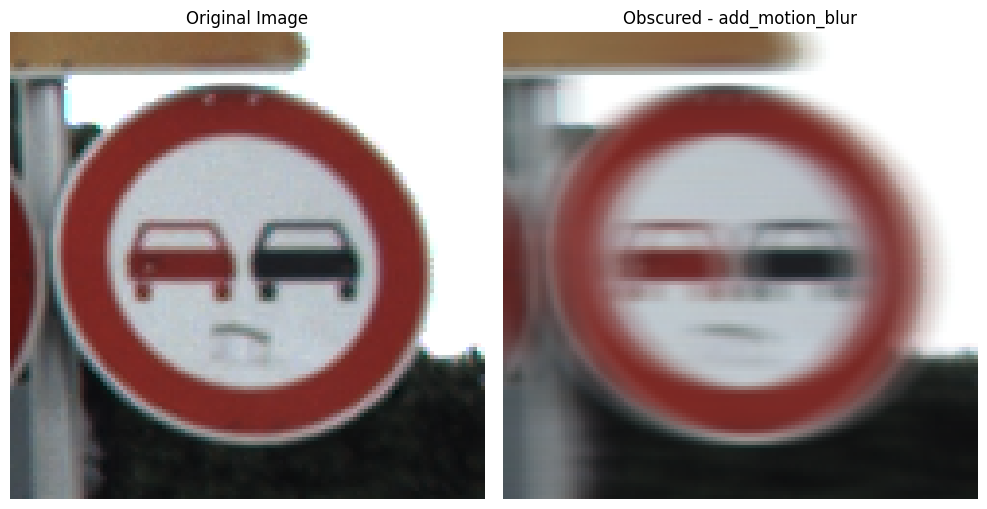

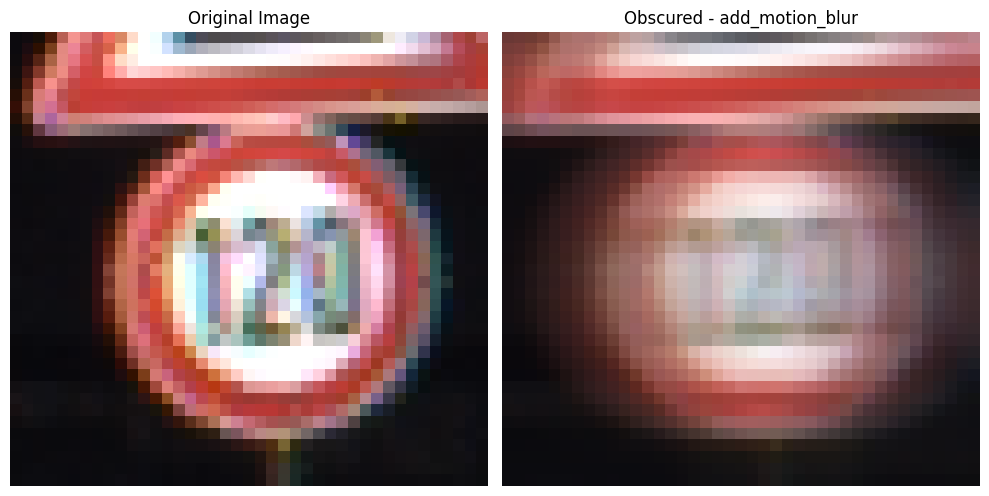

Applying obscuration function 7 out of 11...


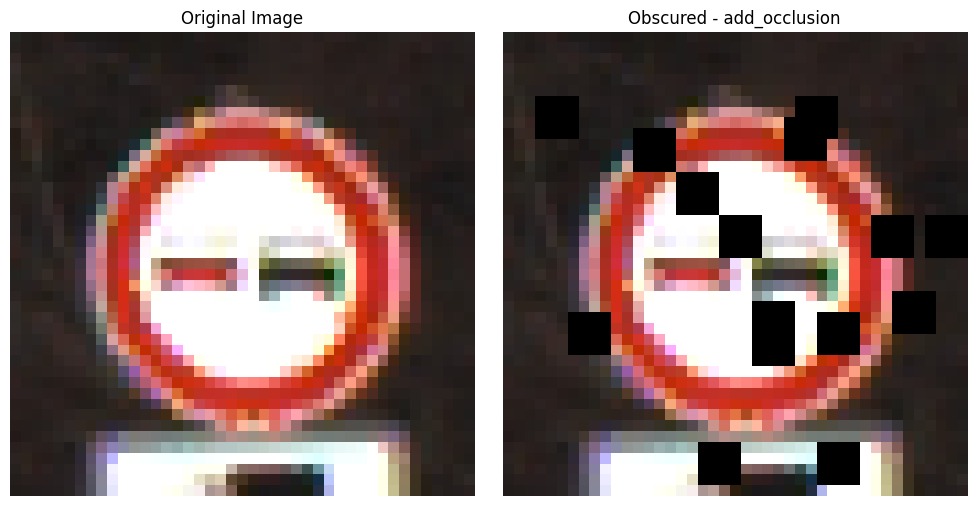

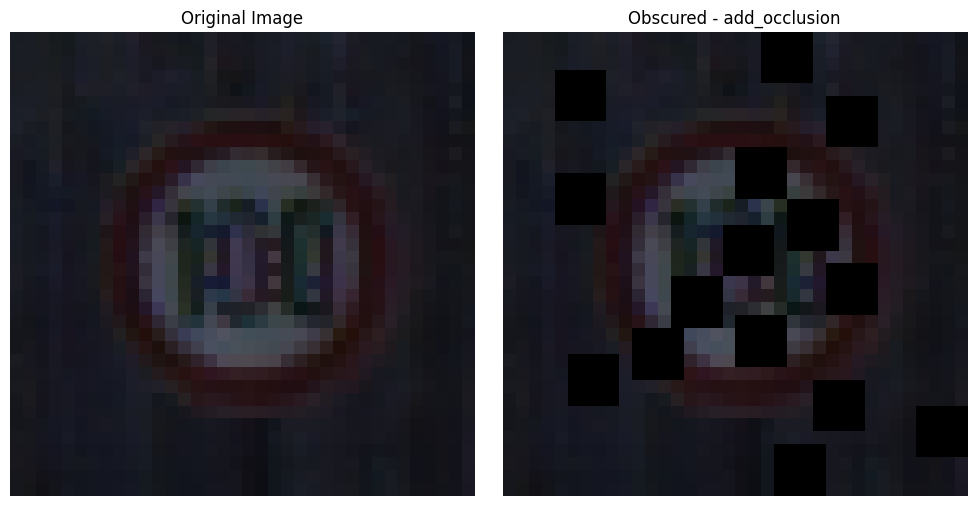

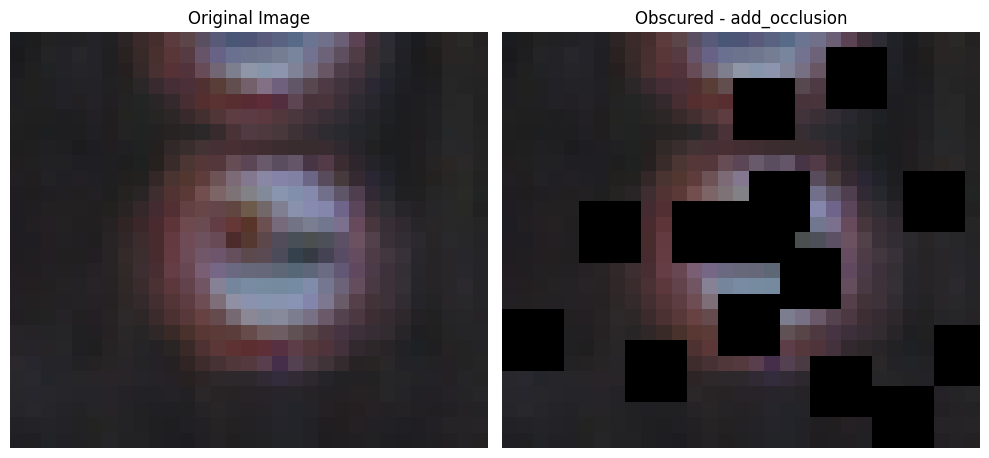

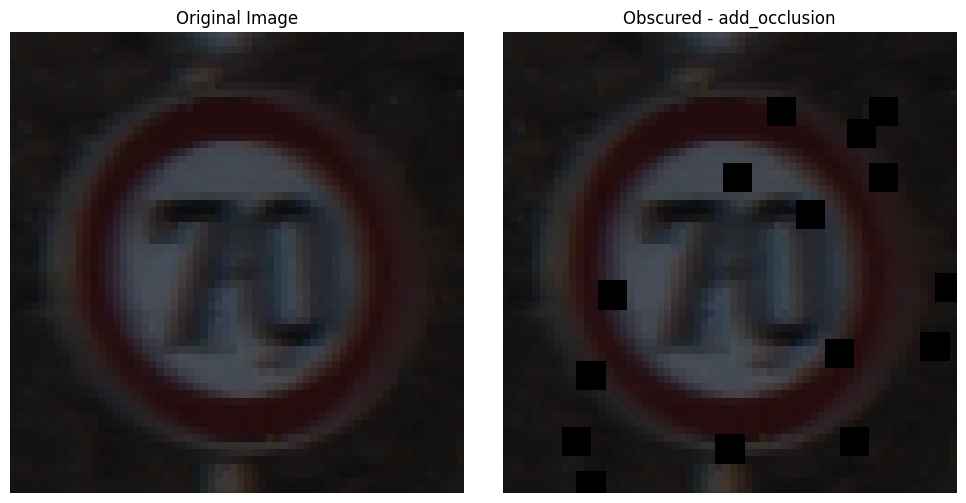

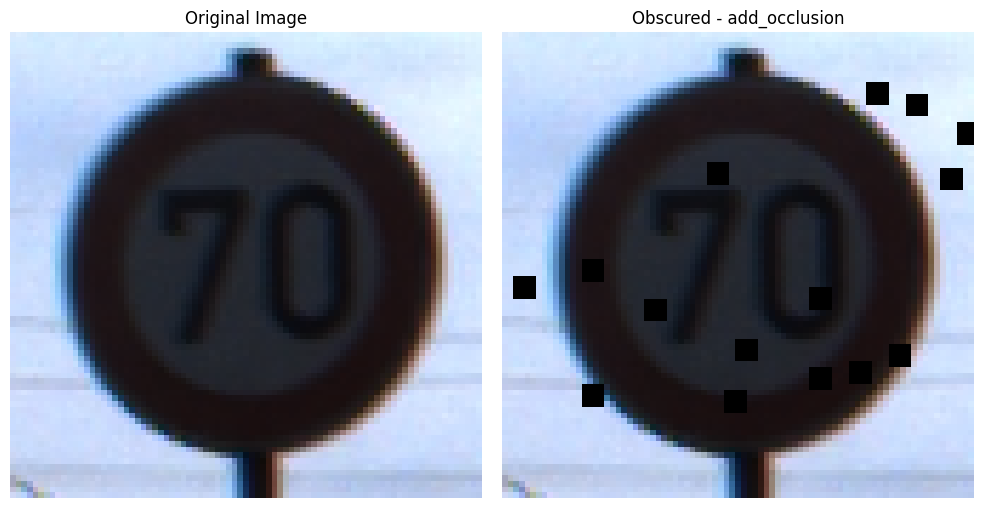

Applying obscuration function 8 out of 11...


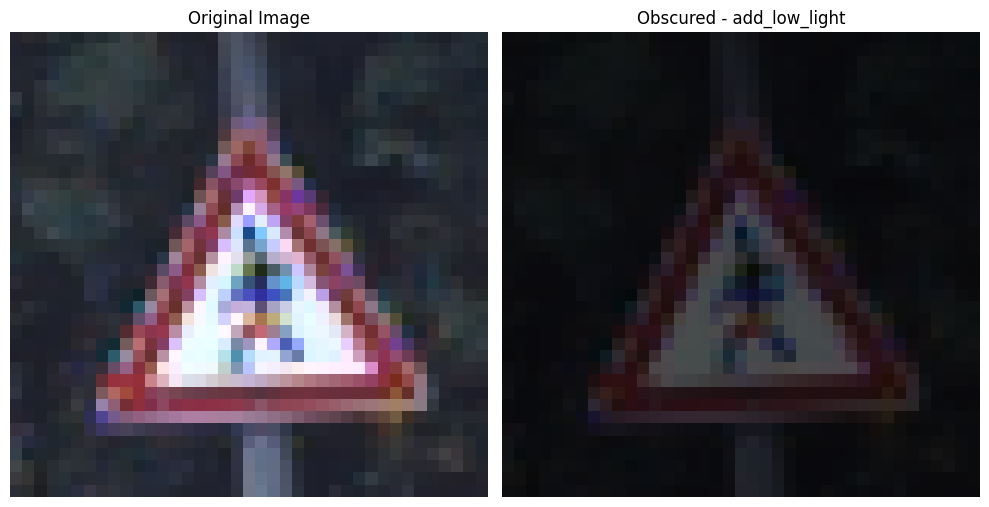

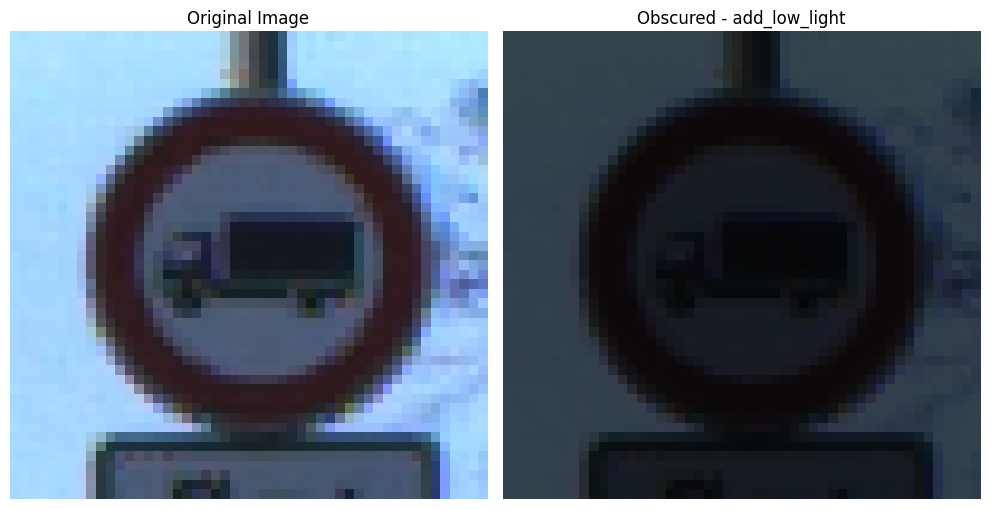

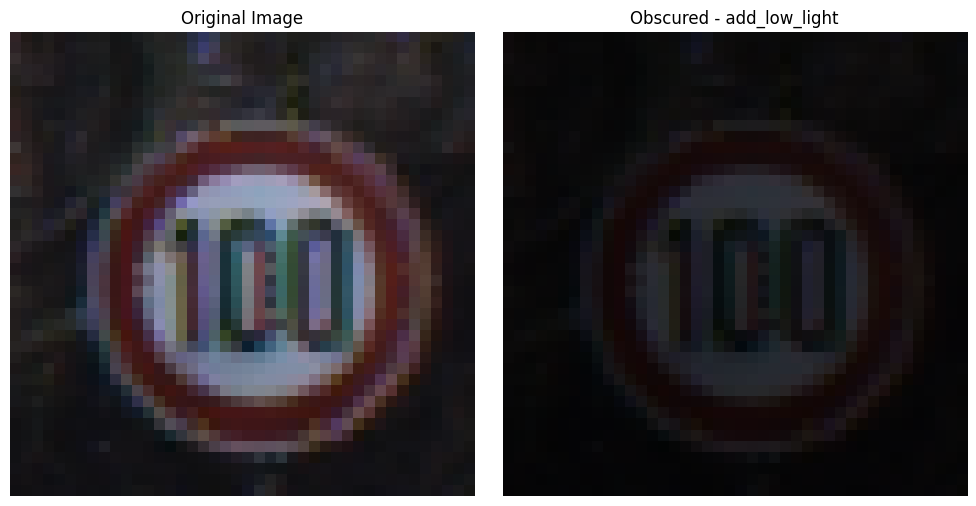

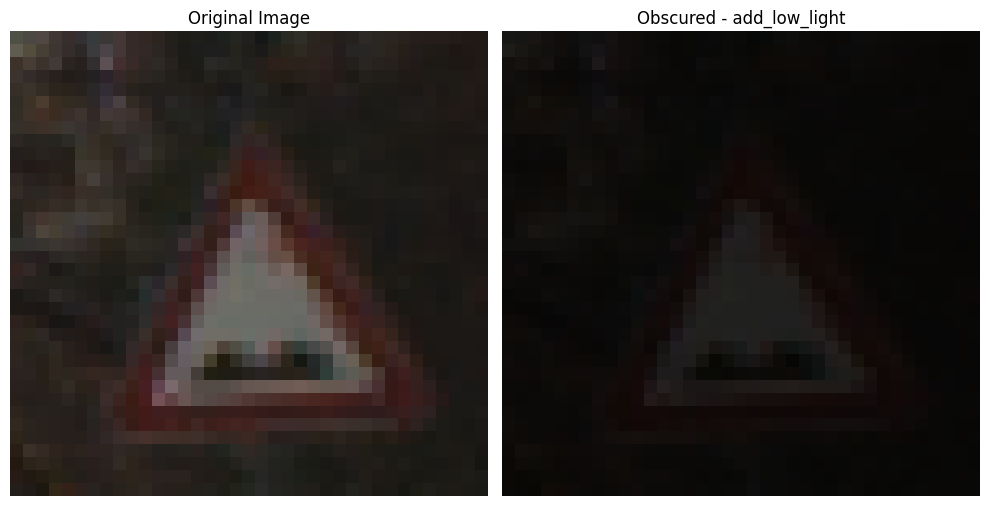

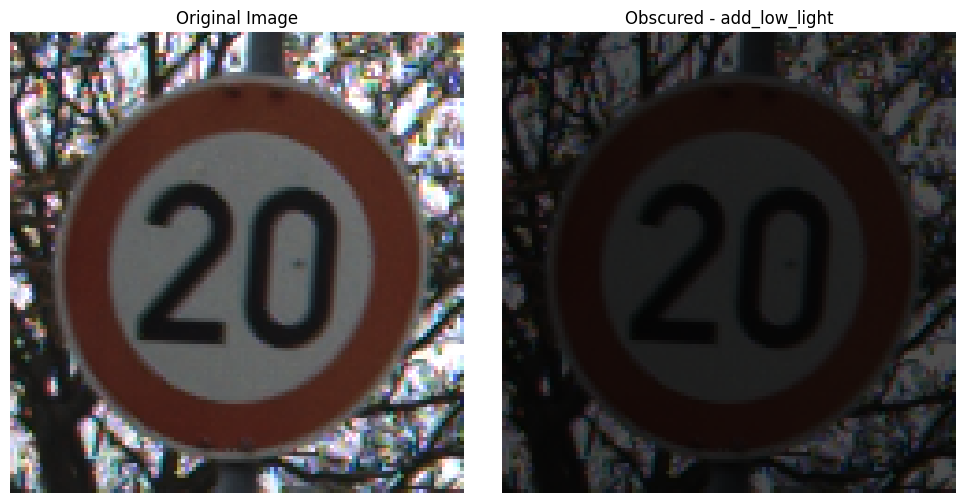

Applying obscuration function 9 out of 11...


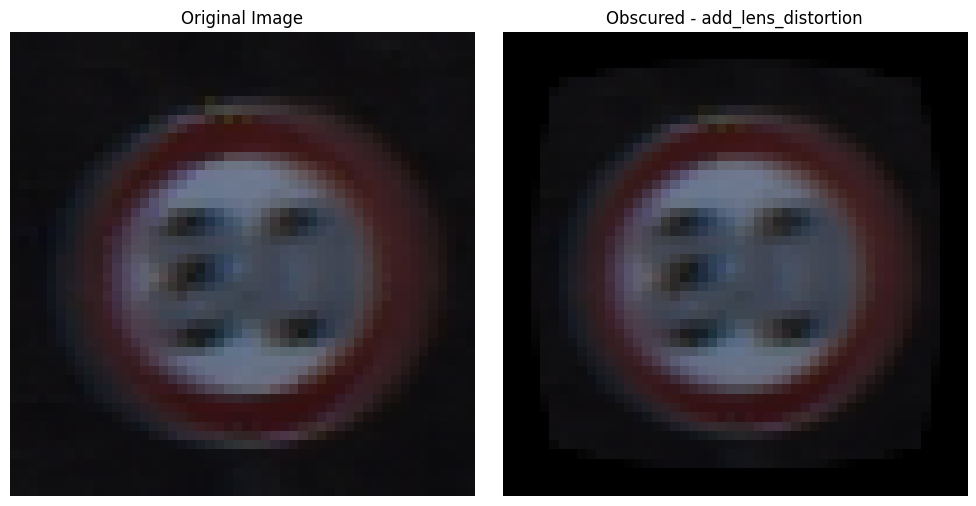

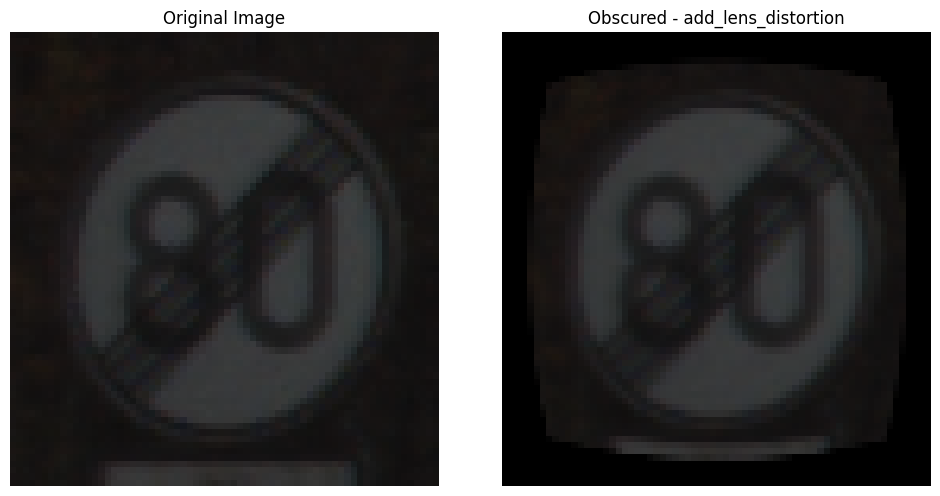

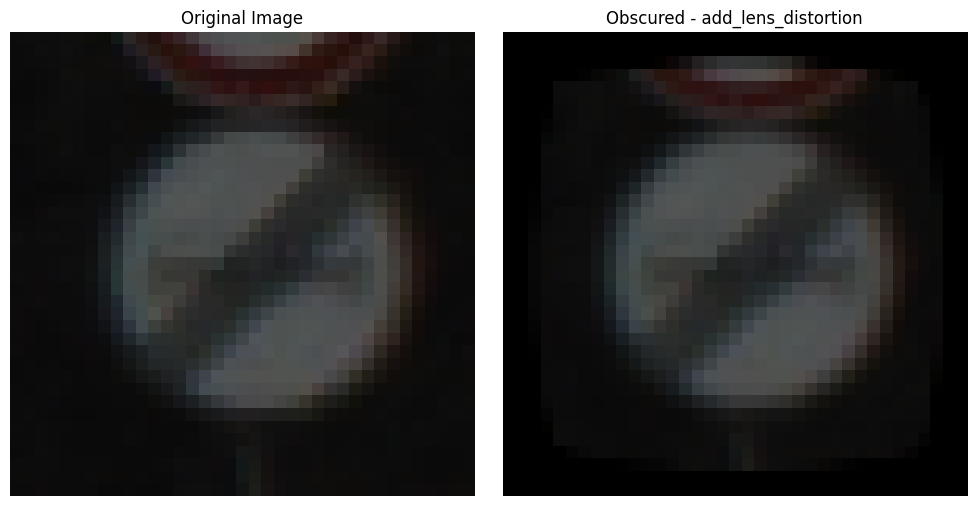

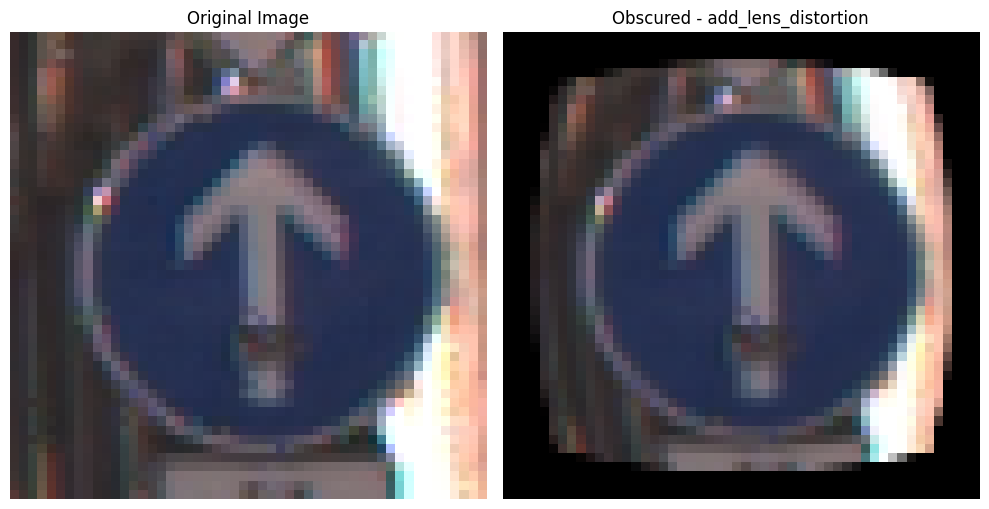

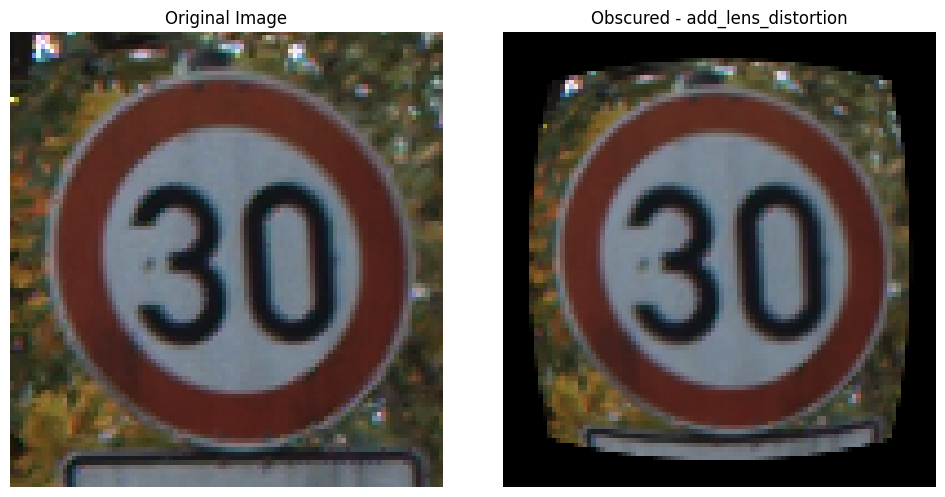

Applying obscuration function 10 out of 11...


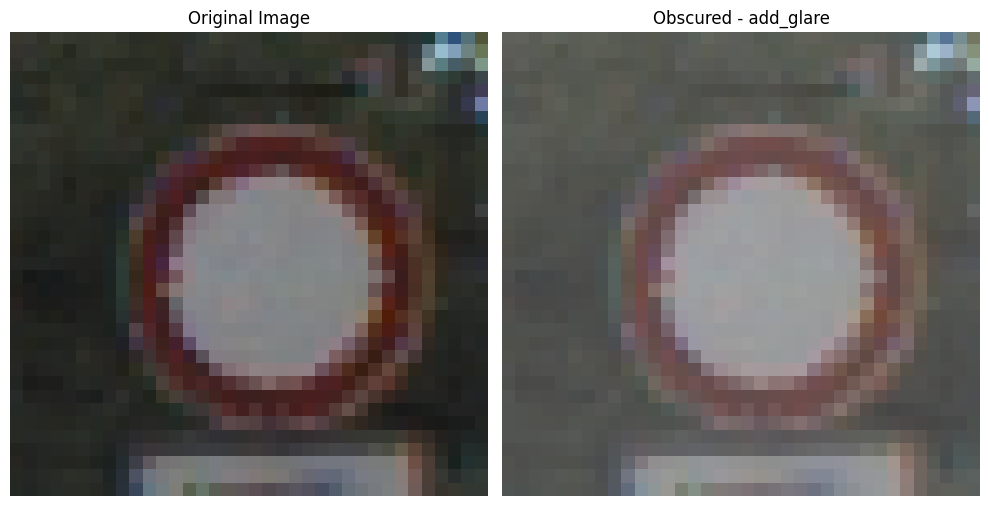

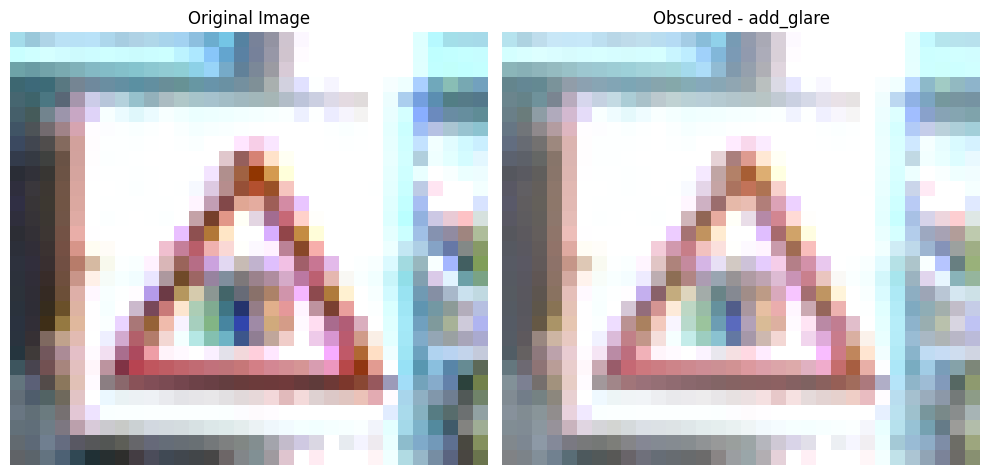

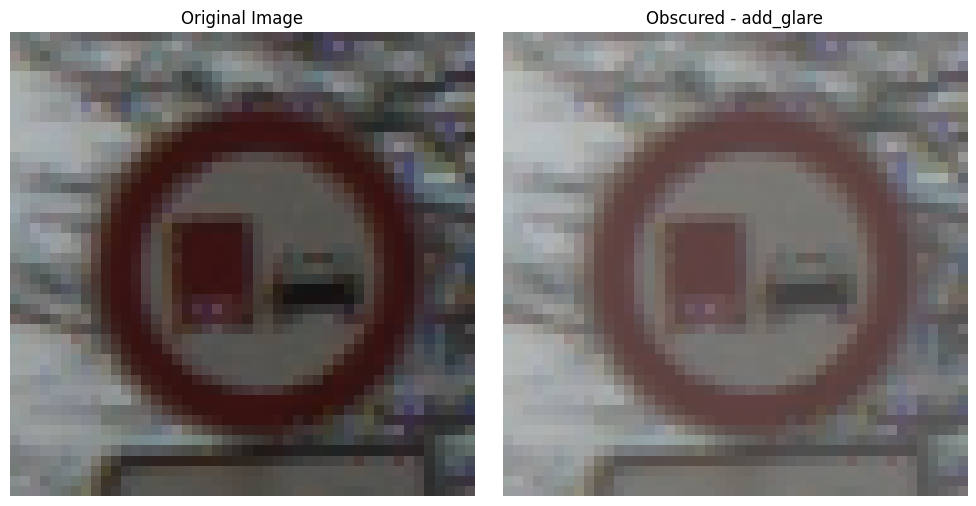

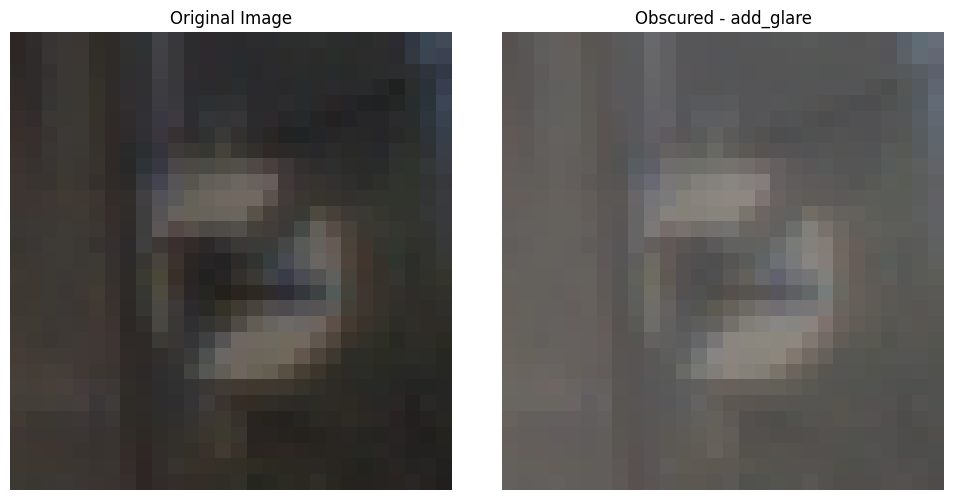

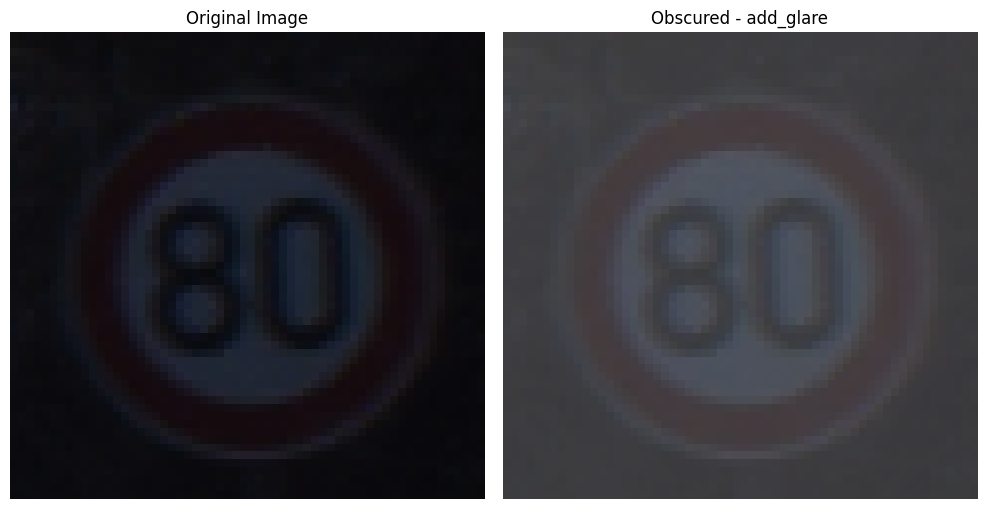

Applying obscuration function 11 out of 11...


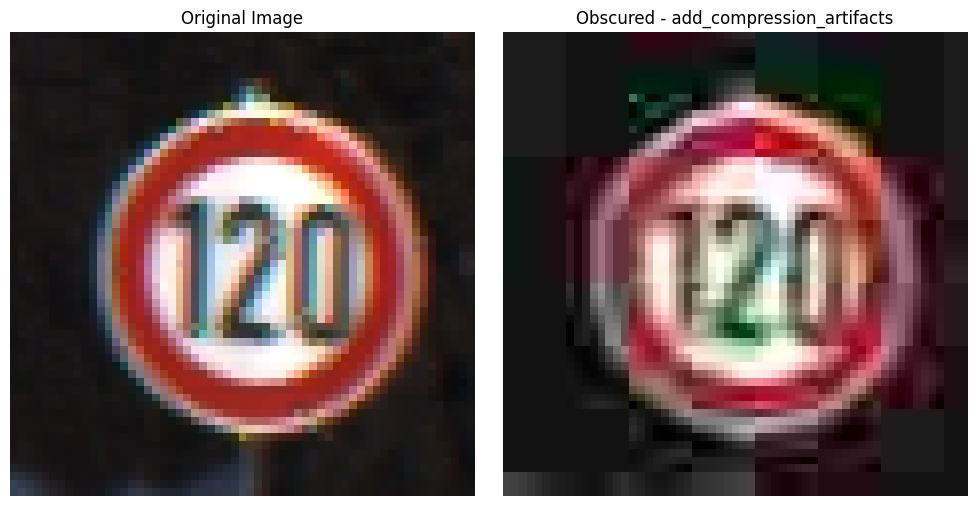

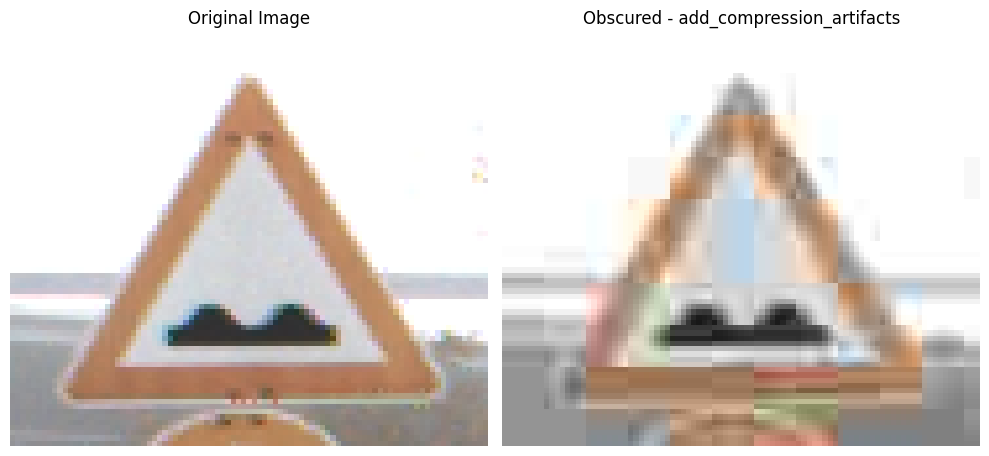

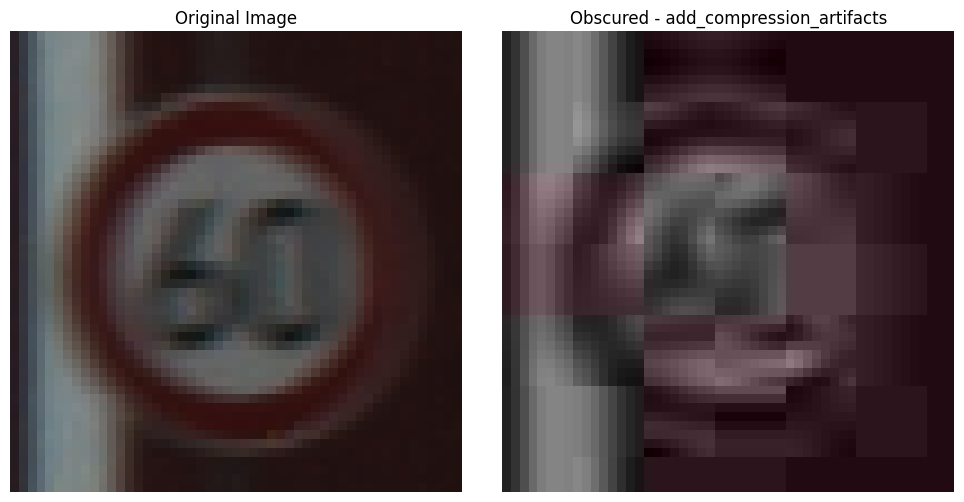

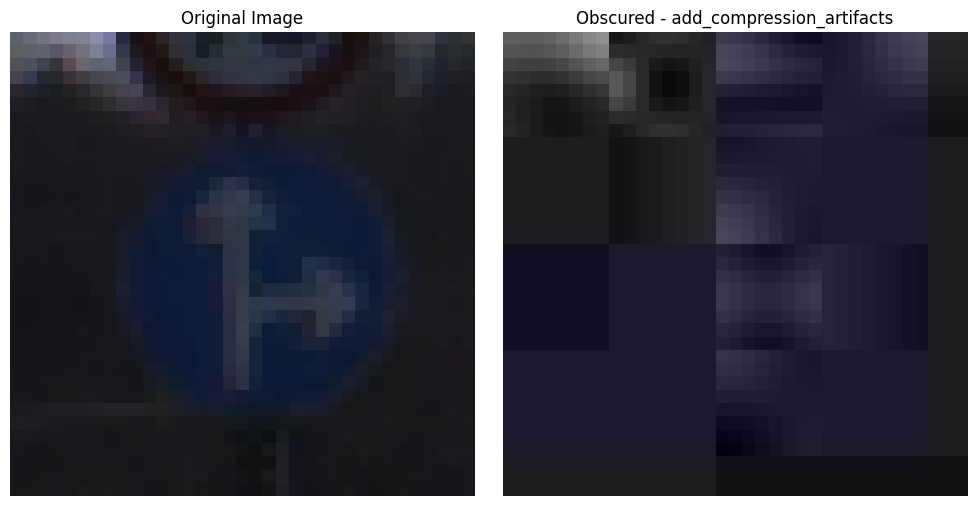

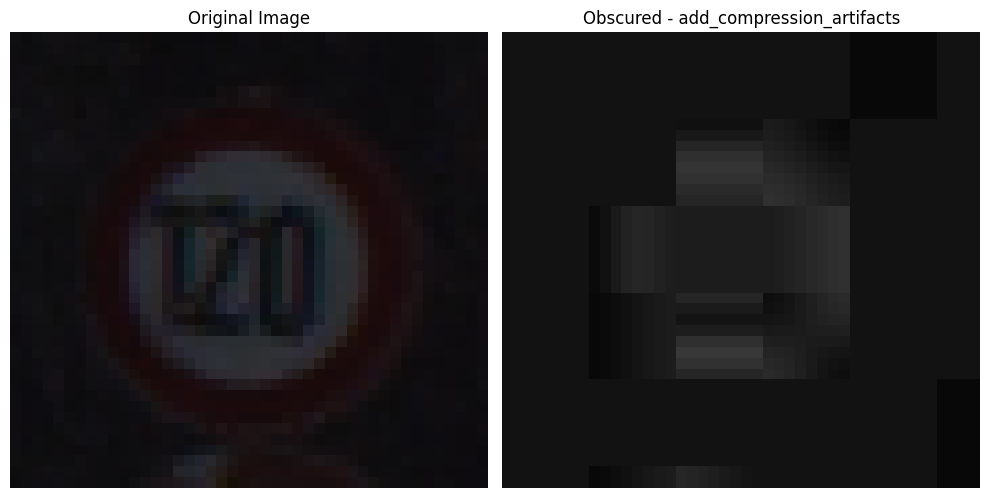

Applying obscuration function 1 out of 11...


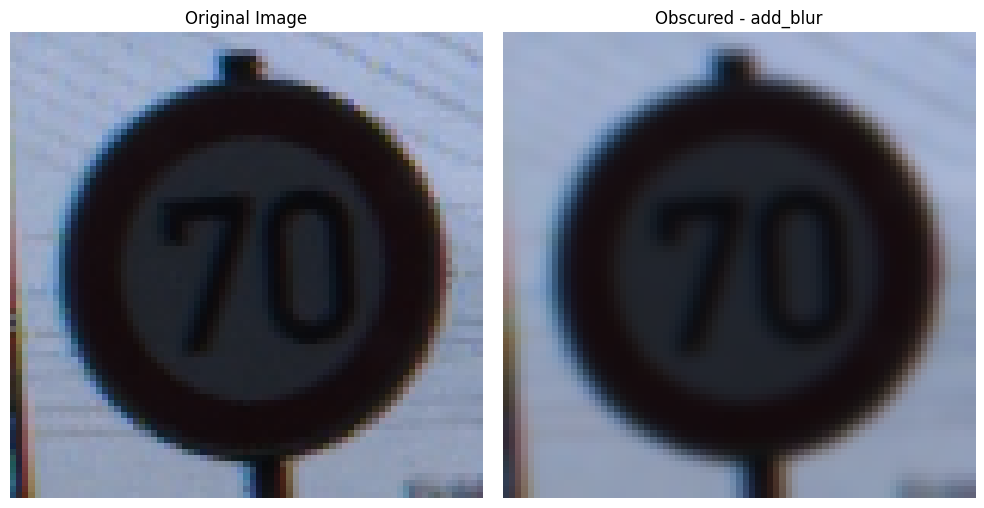

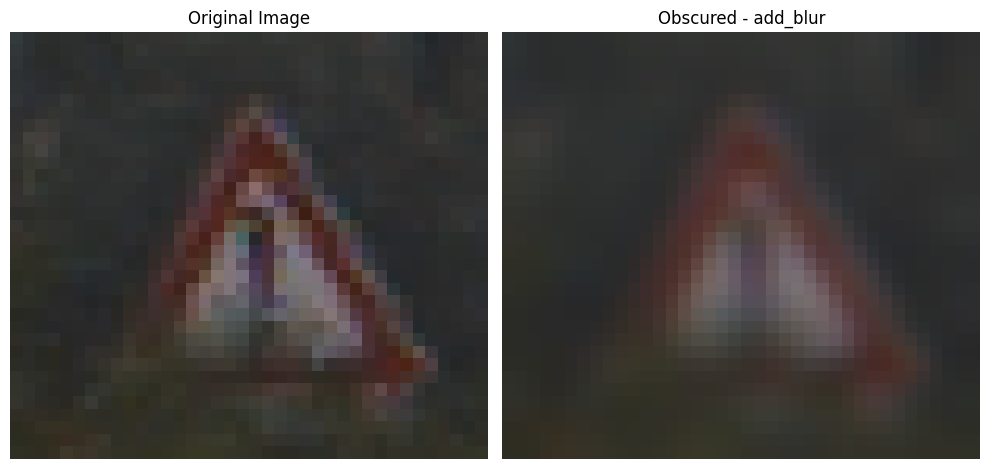

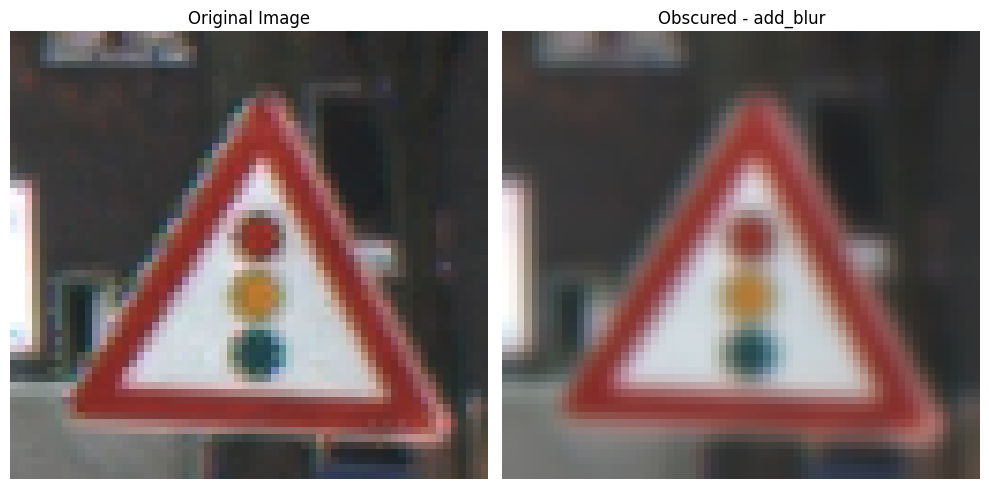

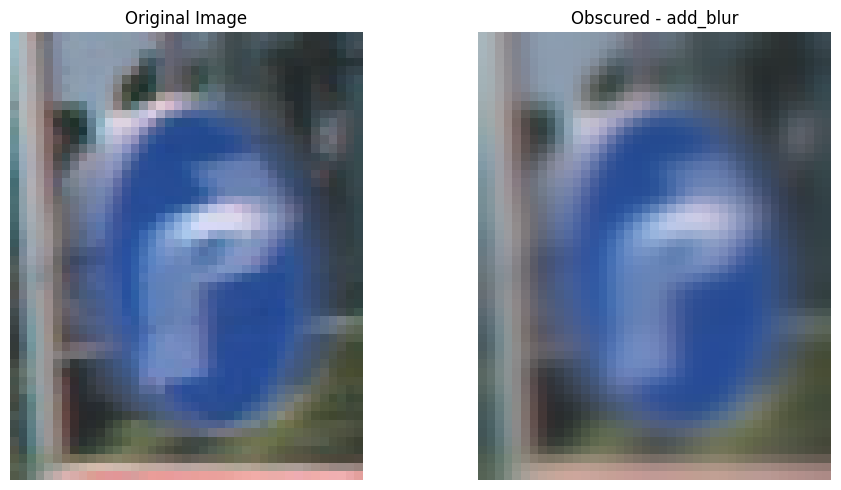

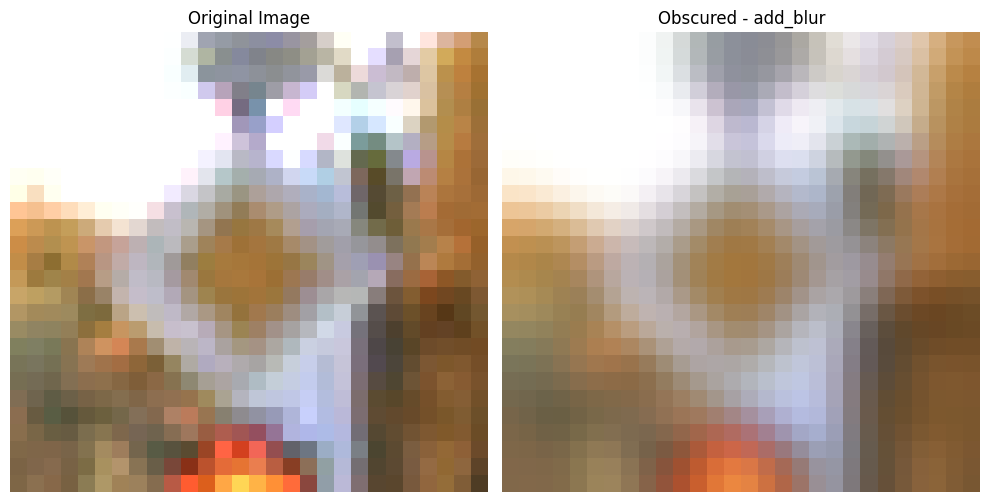

Applying obscuration function 2 out of 11...


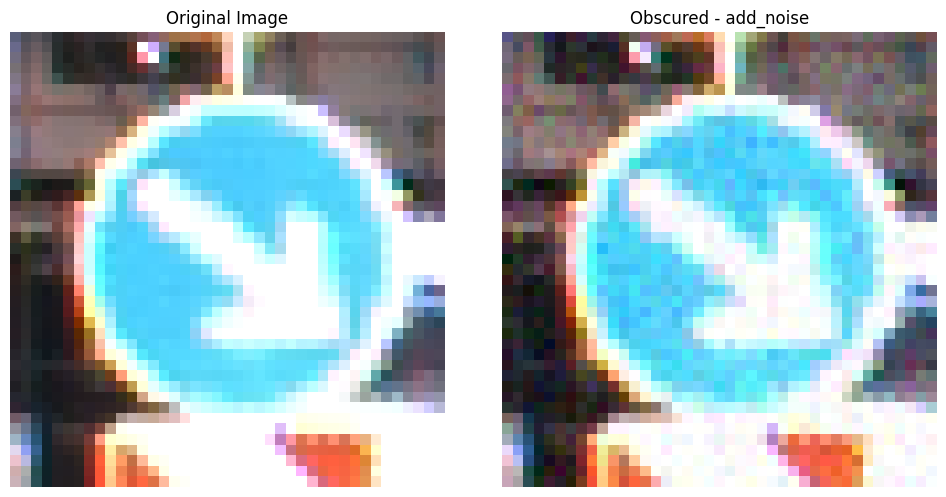

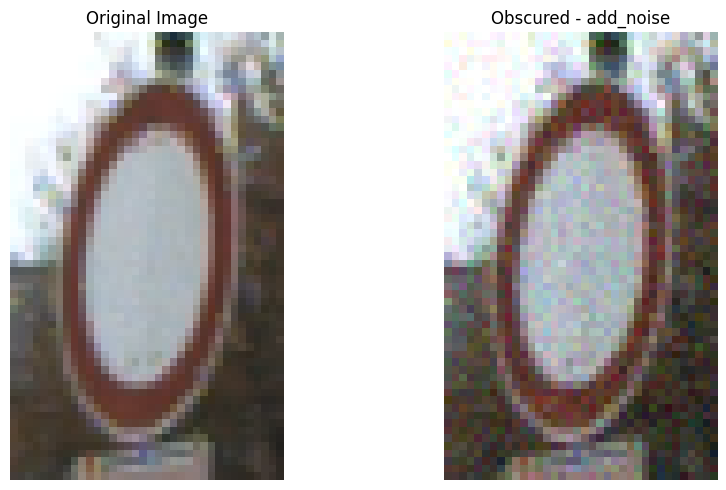

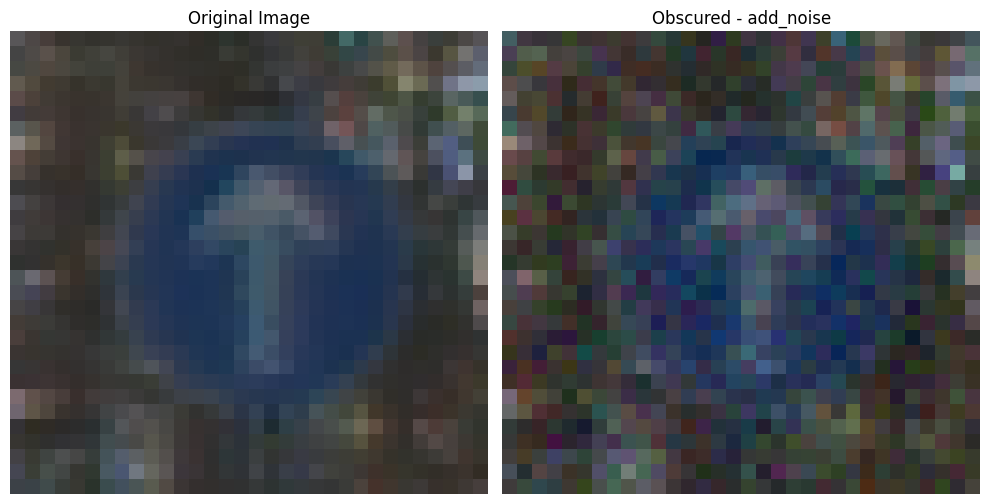

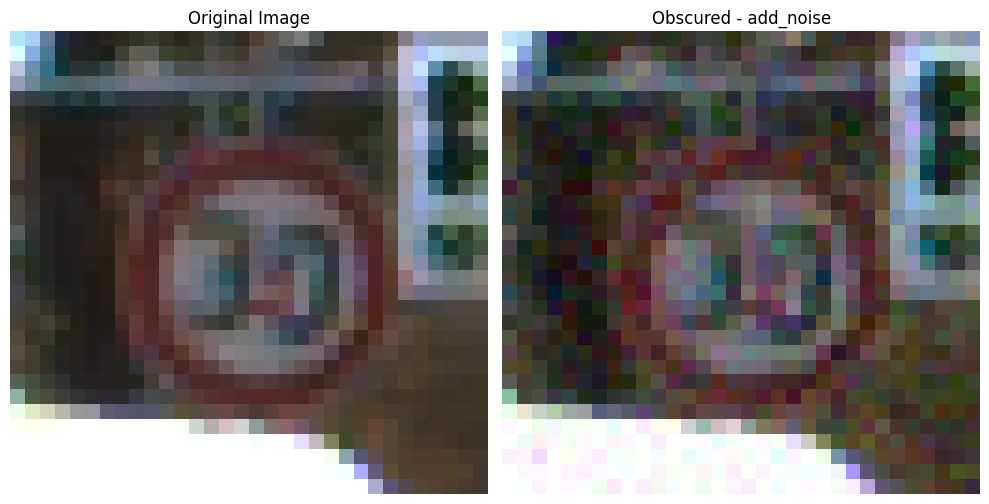

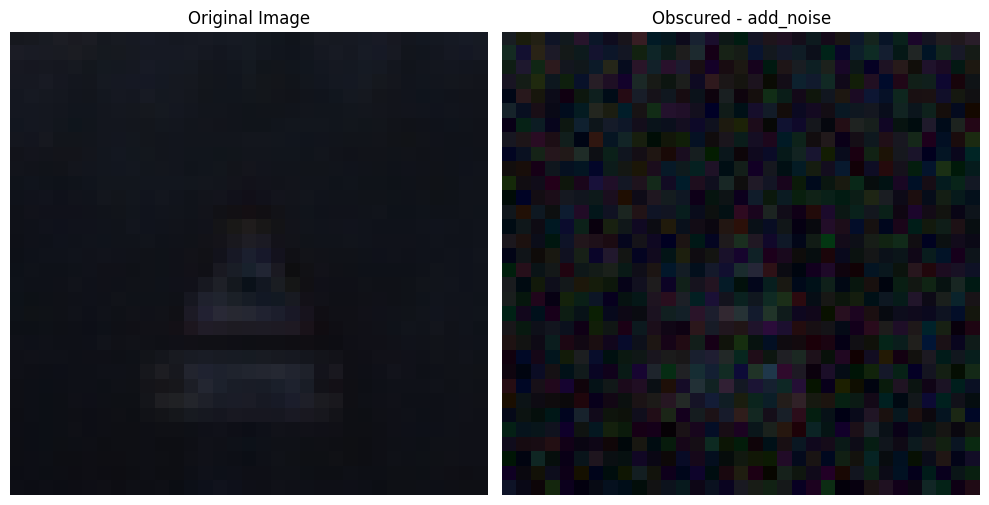

Applying obscuration function 3 out of 11...


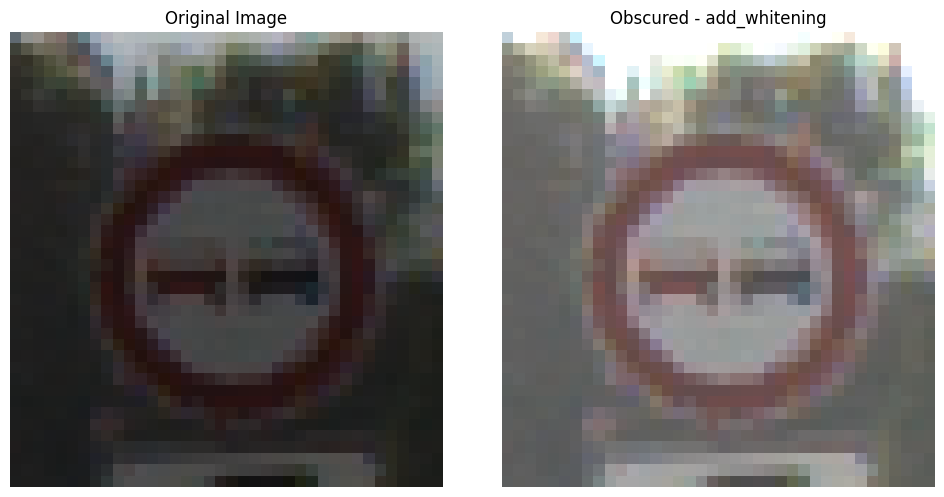

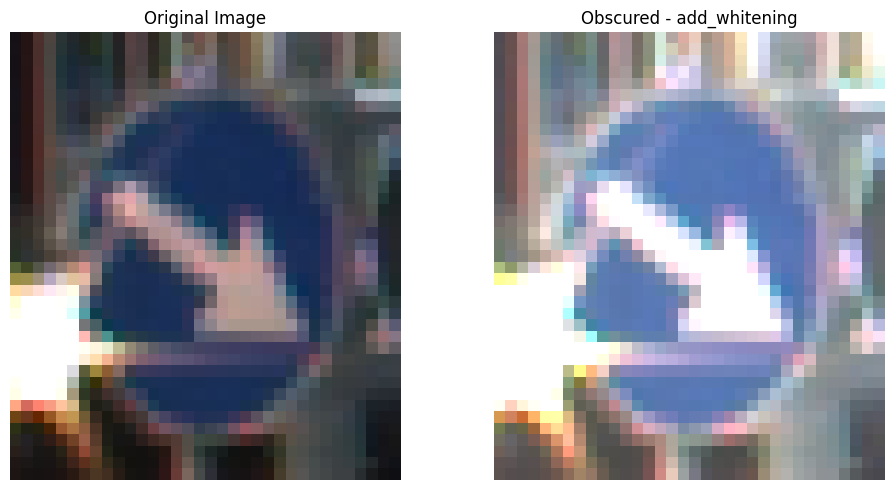

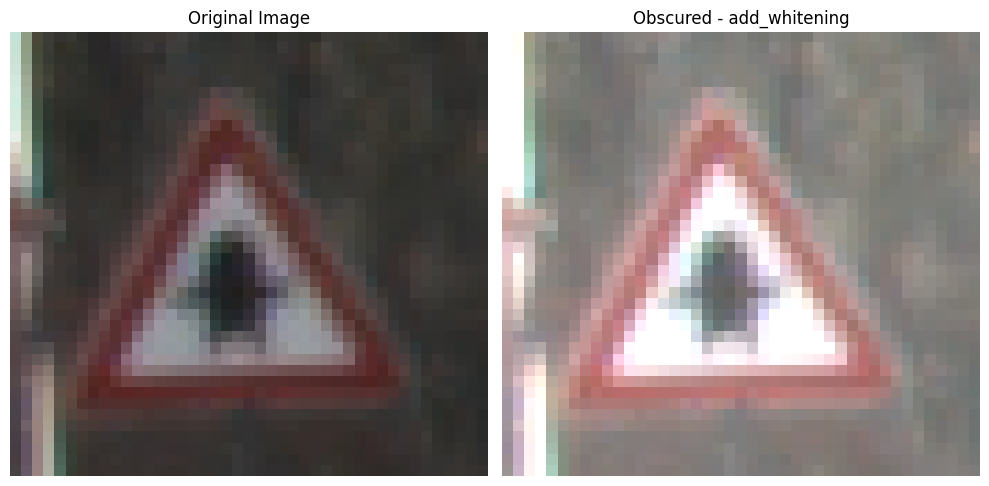

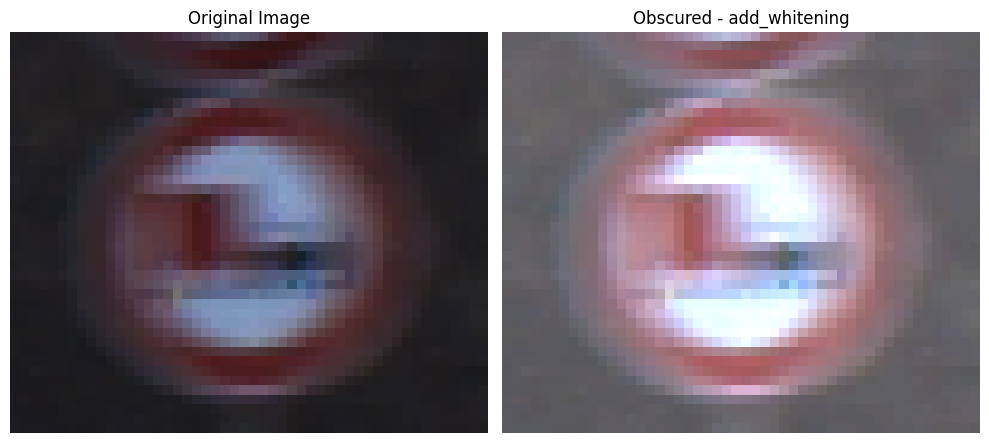

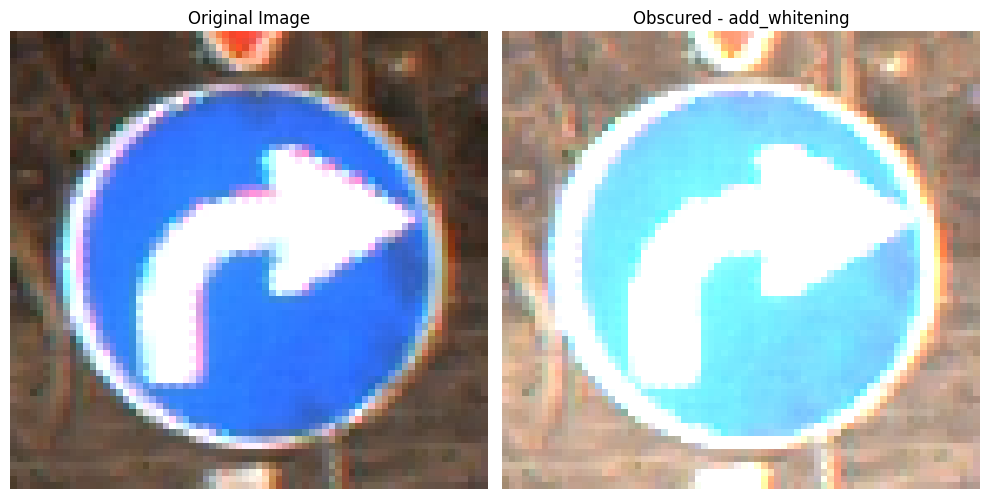

Applying obscuration function 4 out of 11...


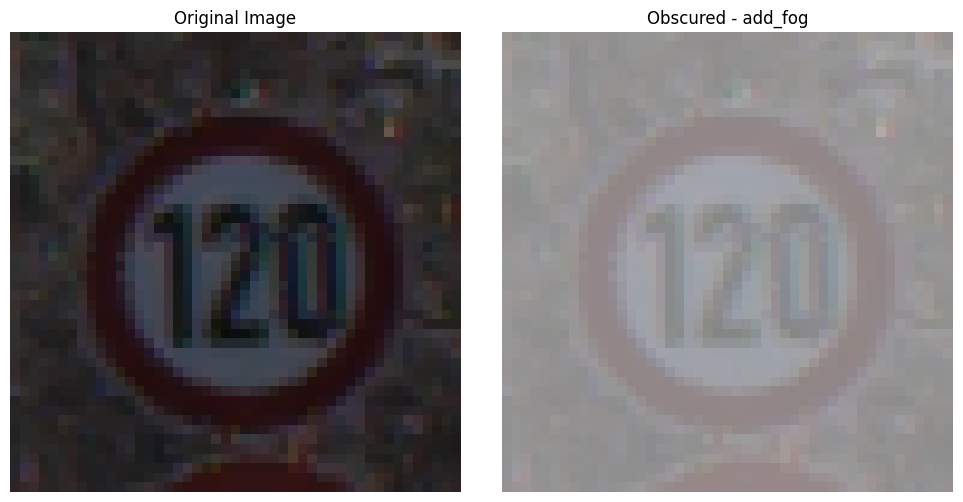

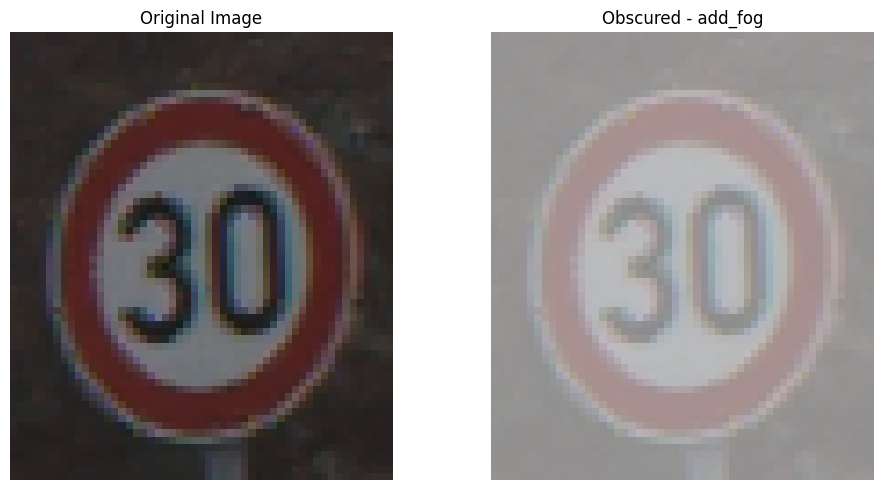

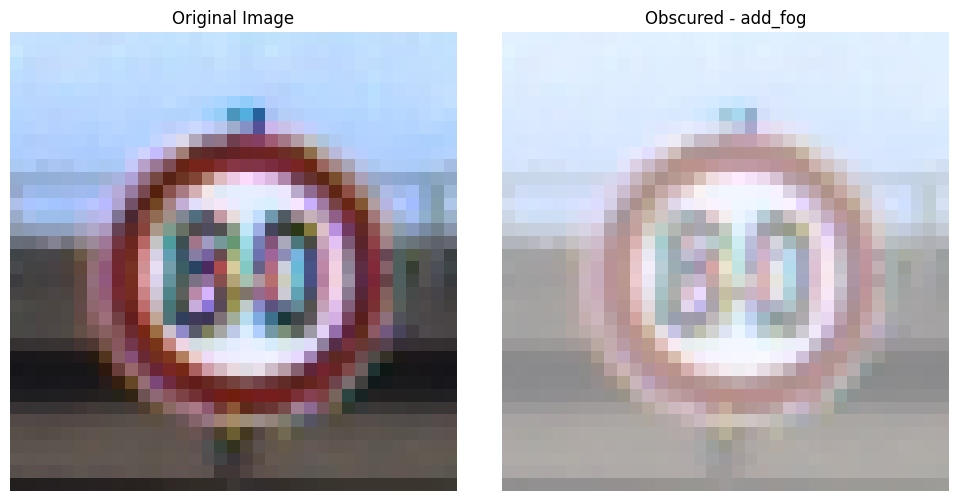

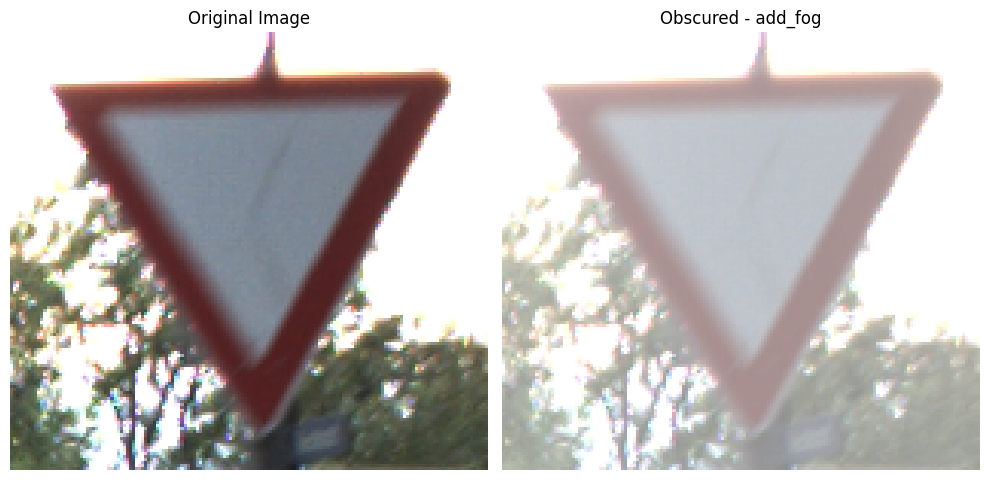

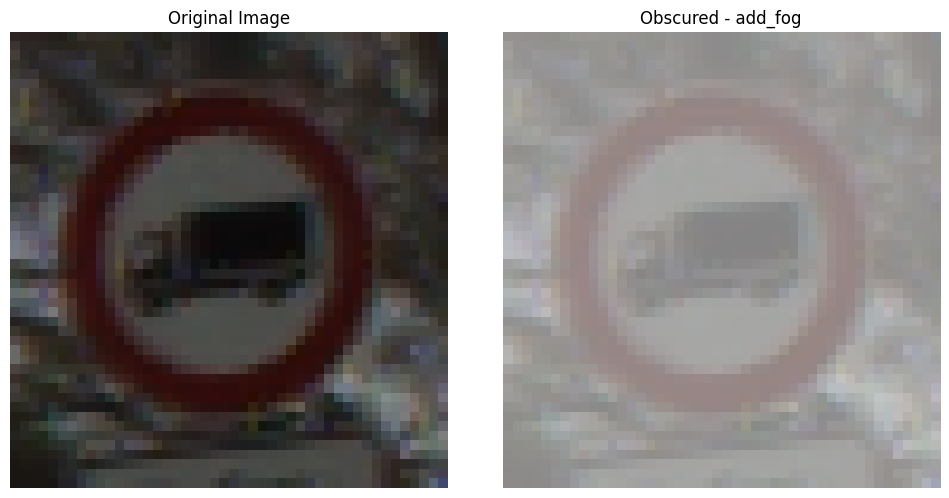

Applying obscuration function 5 out of 11...


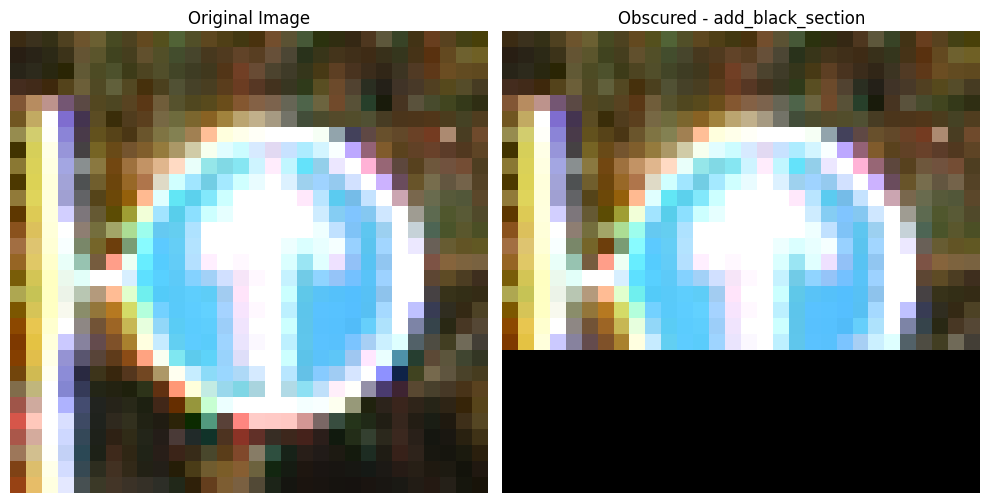

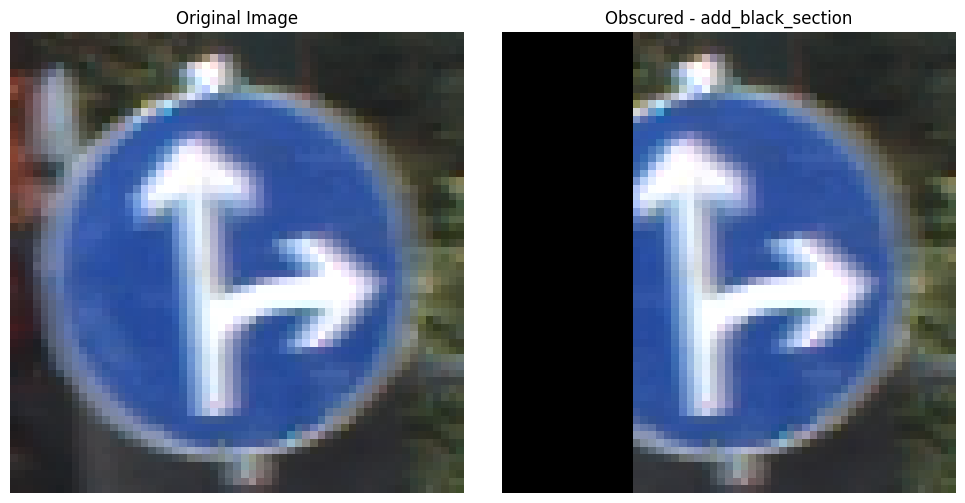

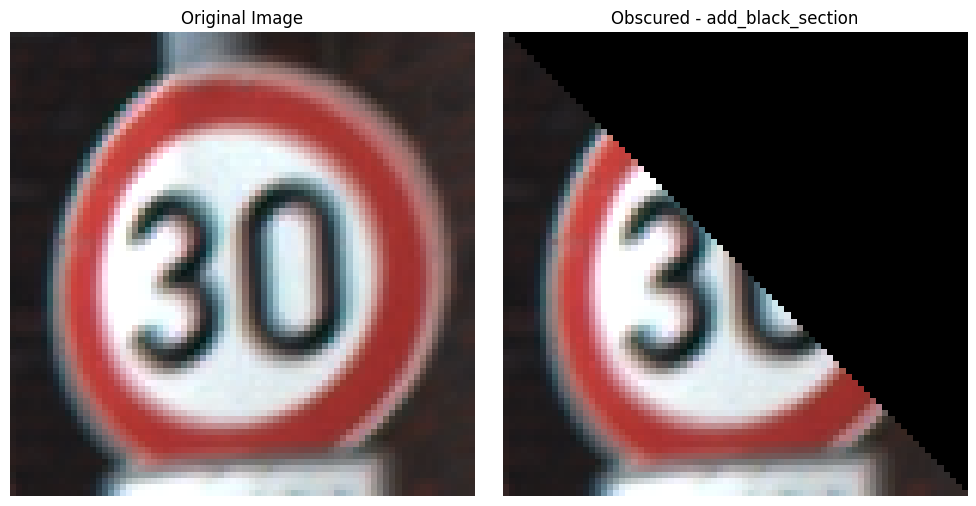

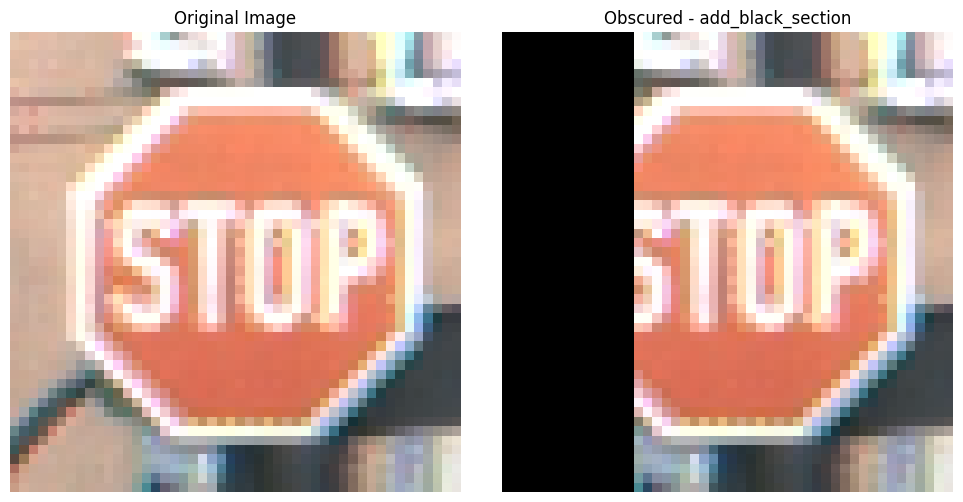

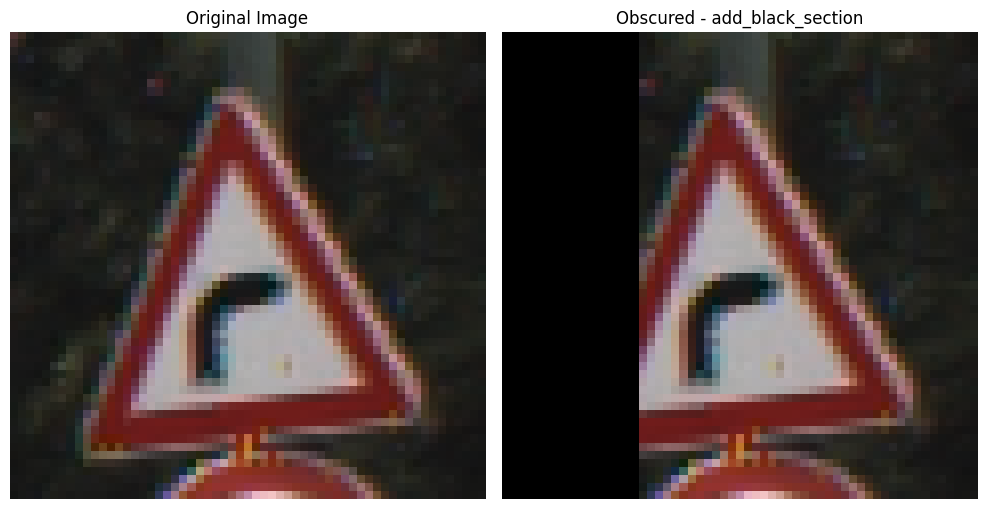

Applying obscuration function 6 out of 11...


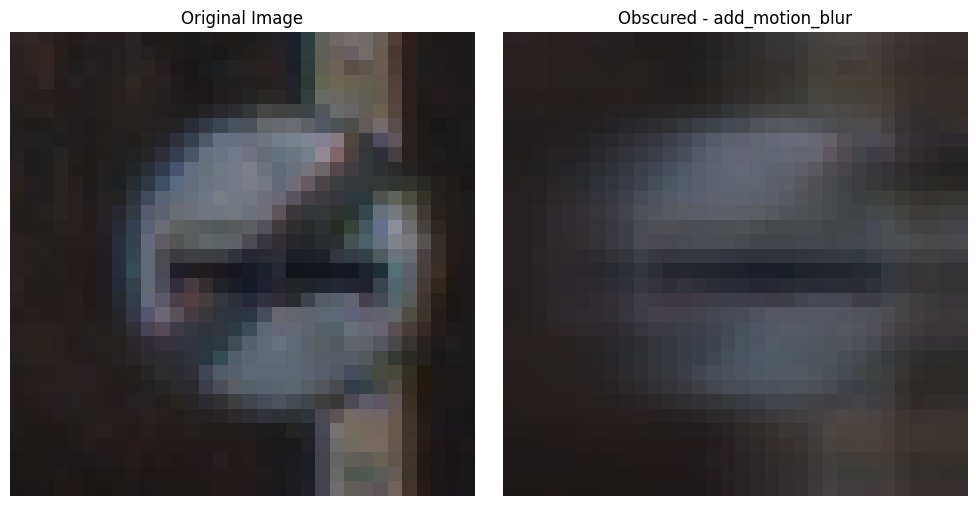

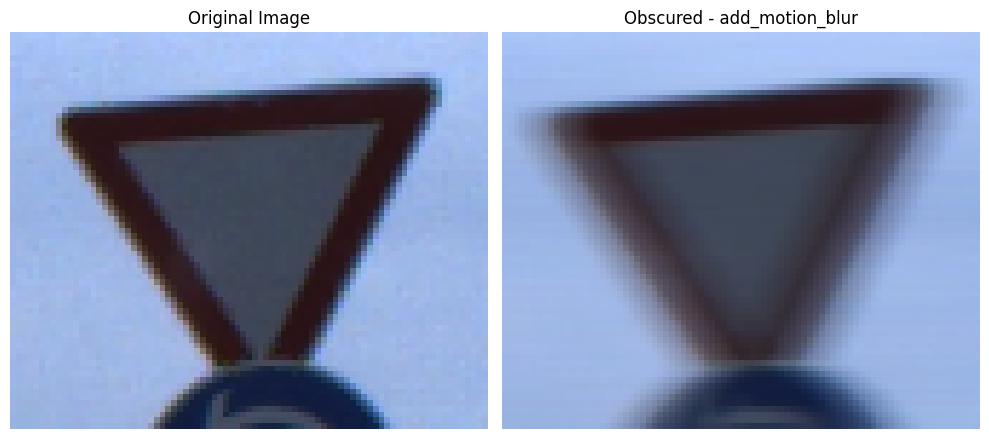

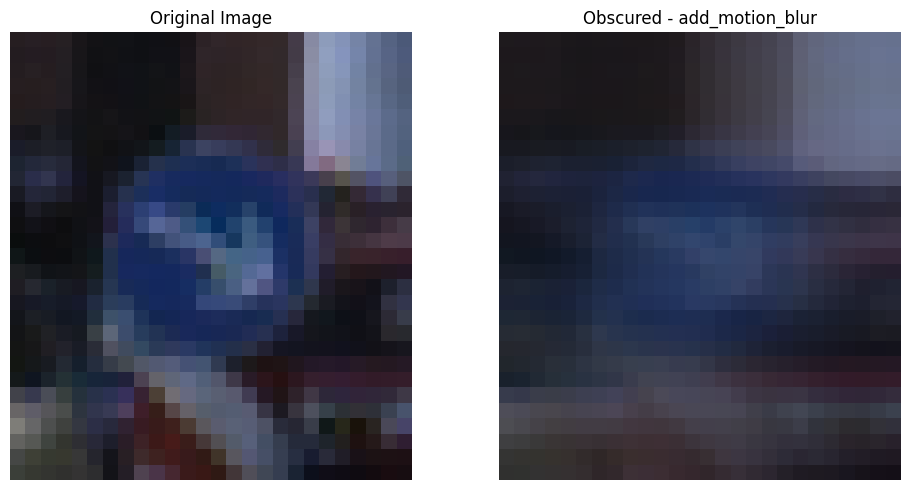

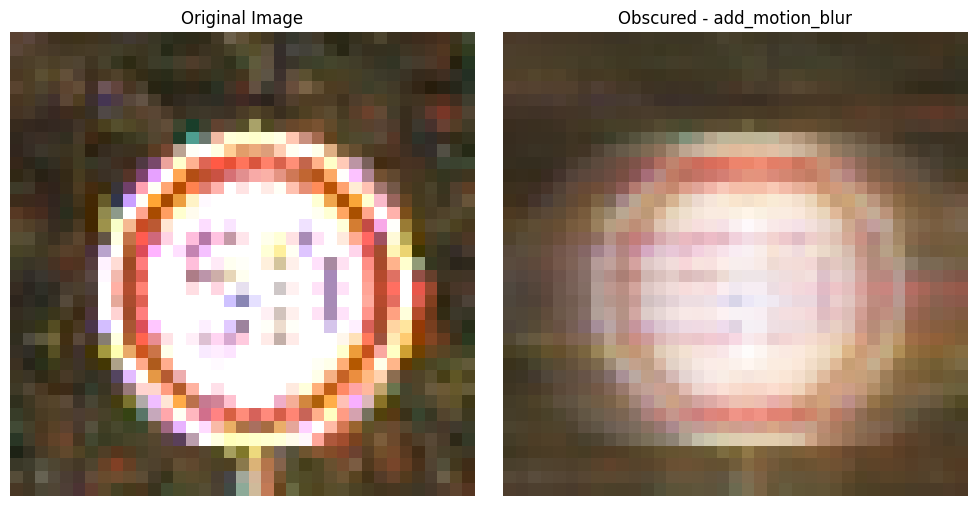

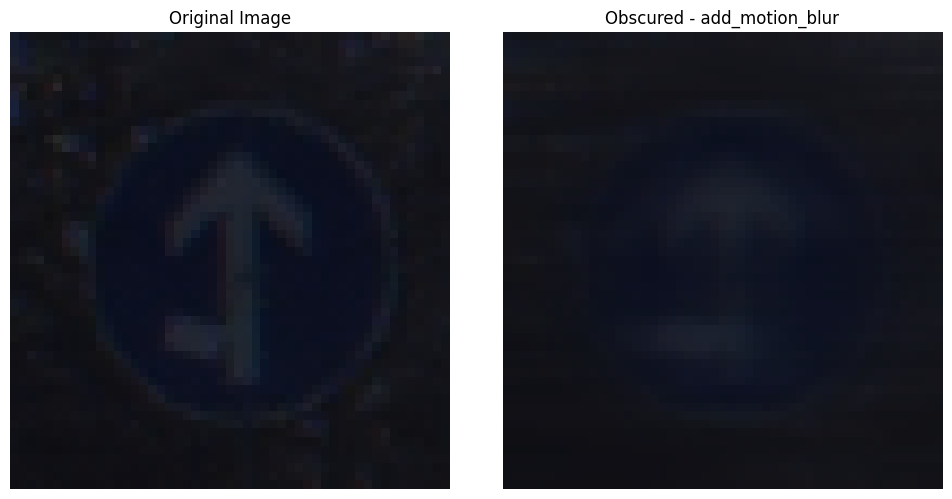

Applying obscuration function 7 out of 11...


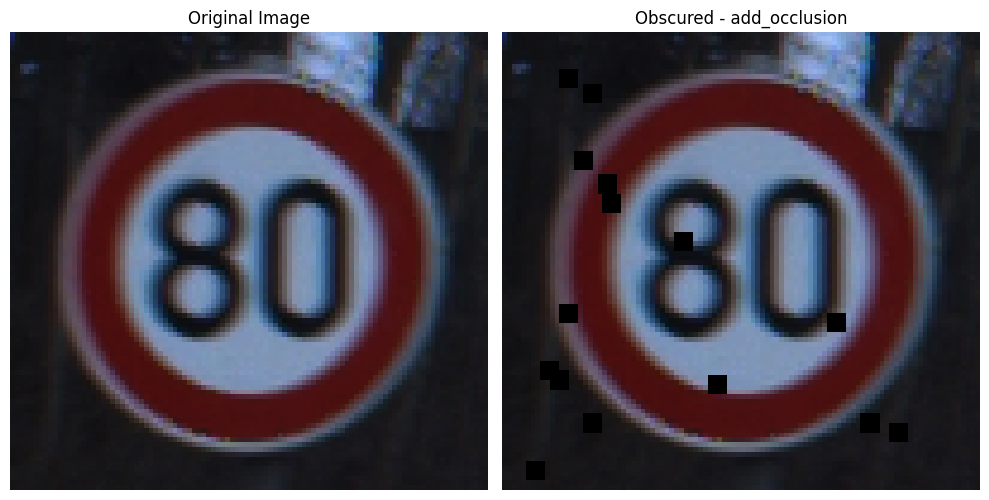

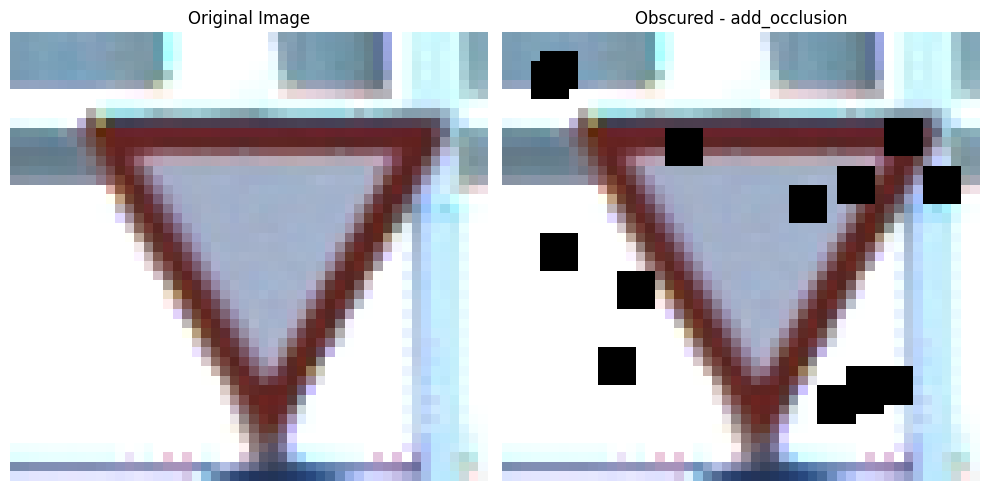

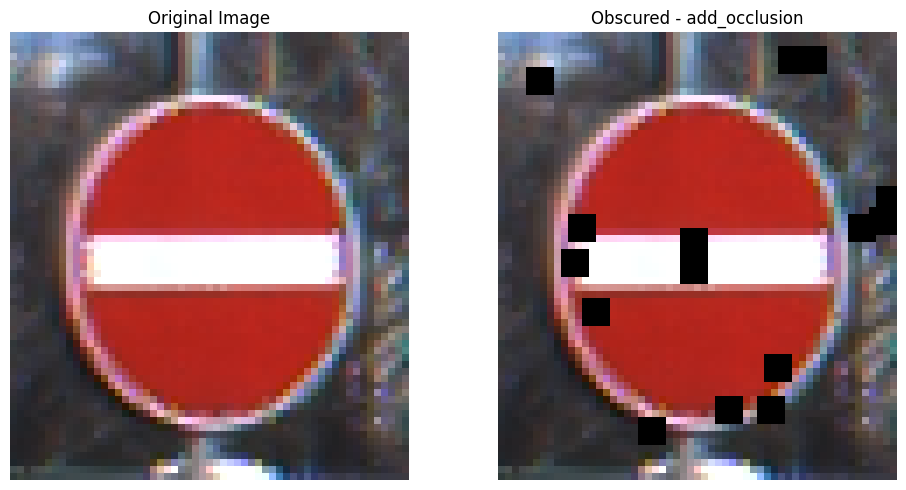

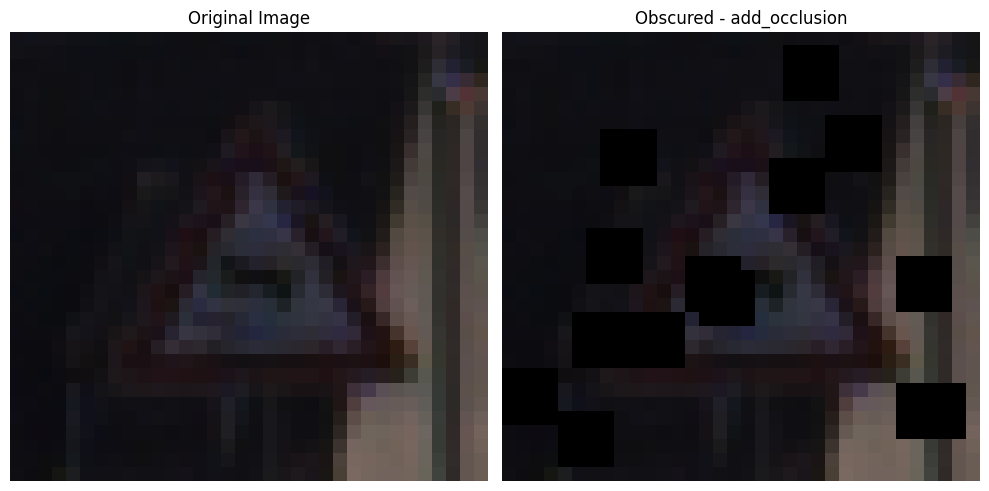

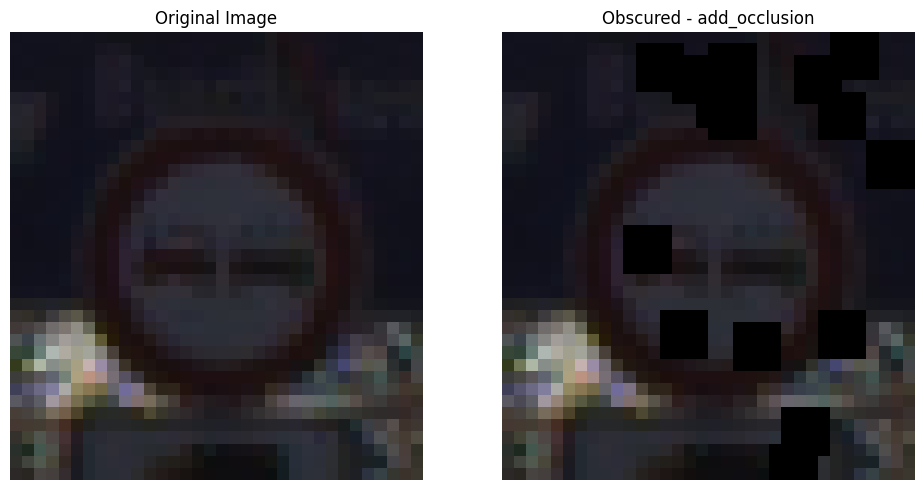

Applying obscuration function 8 out of 11...


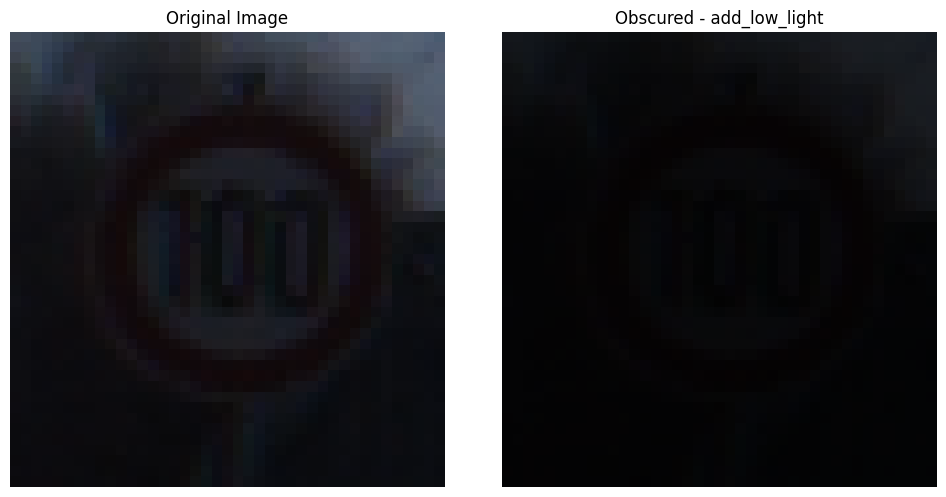

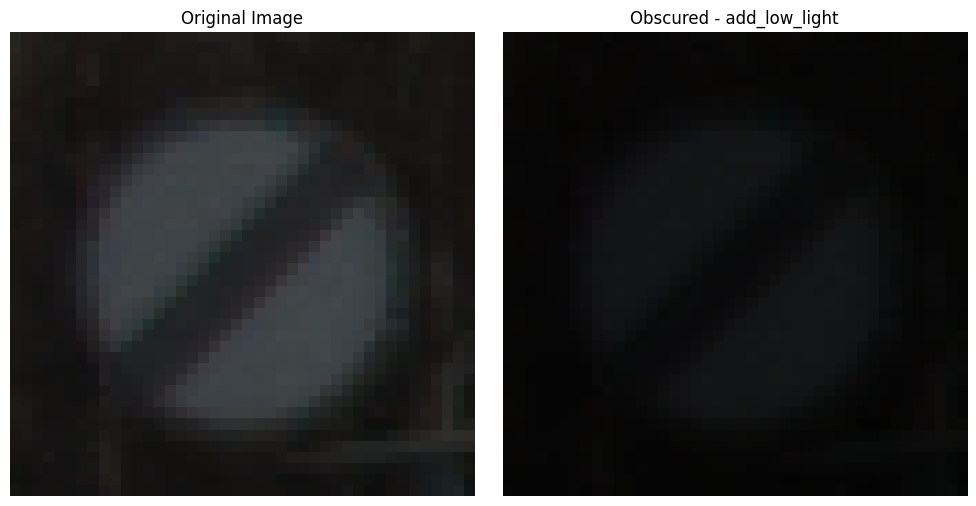

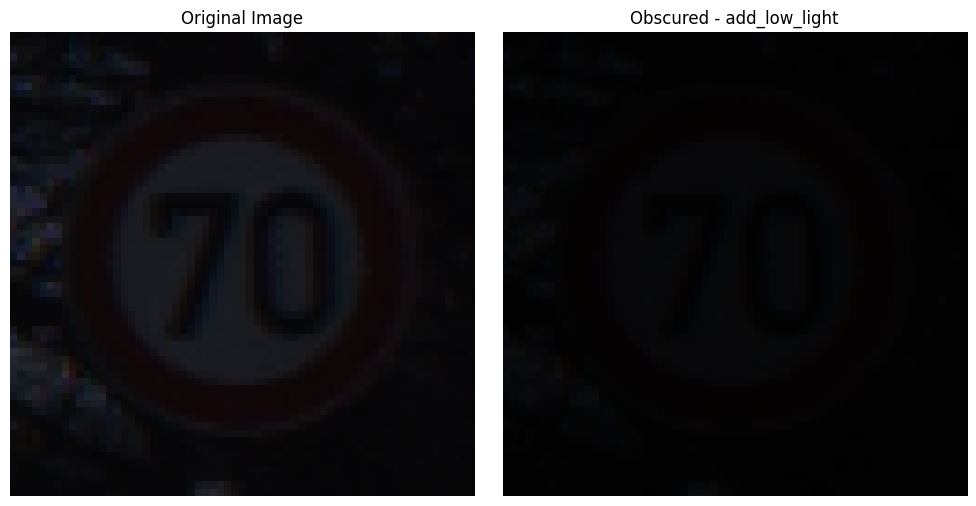

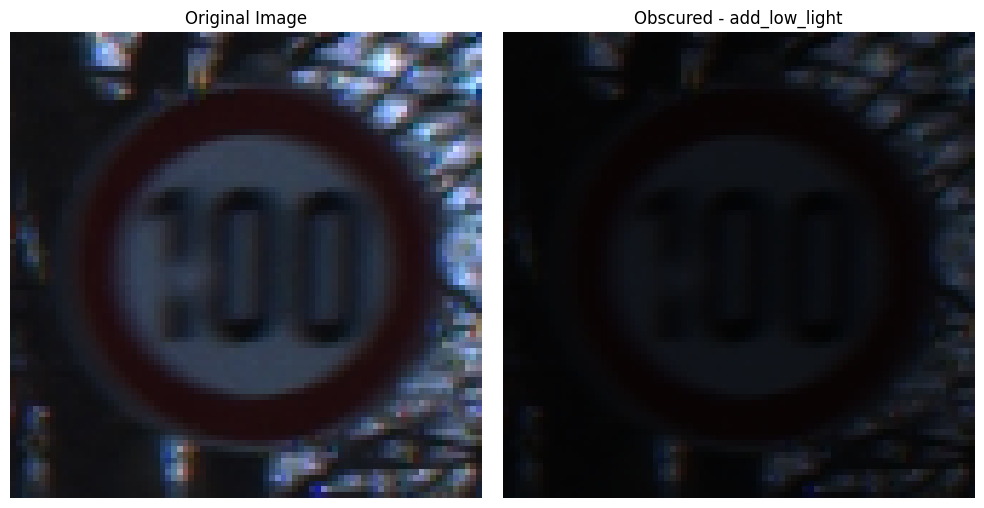

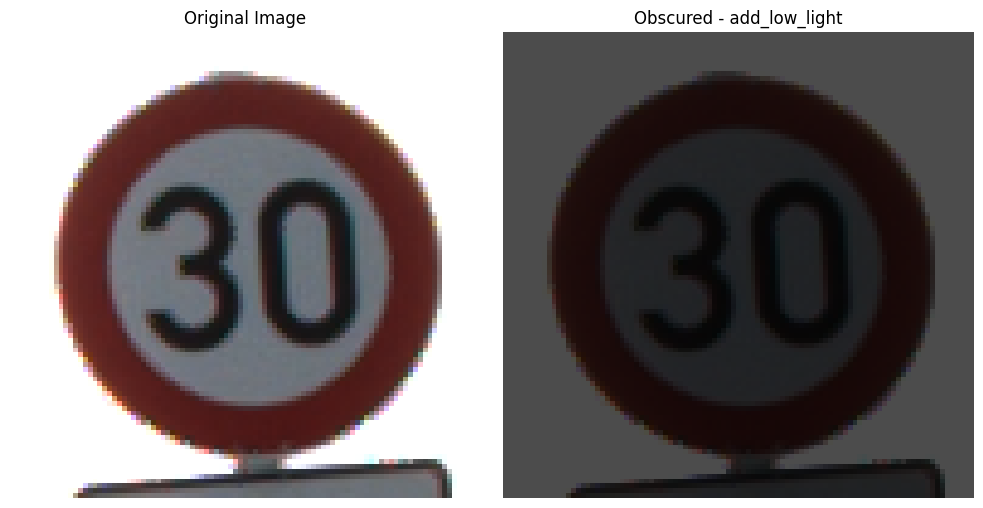

Applying obscuration function 9 out of 11...


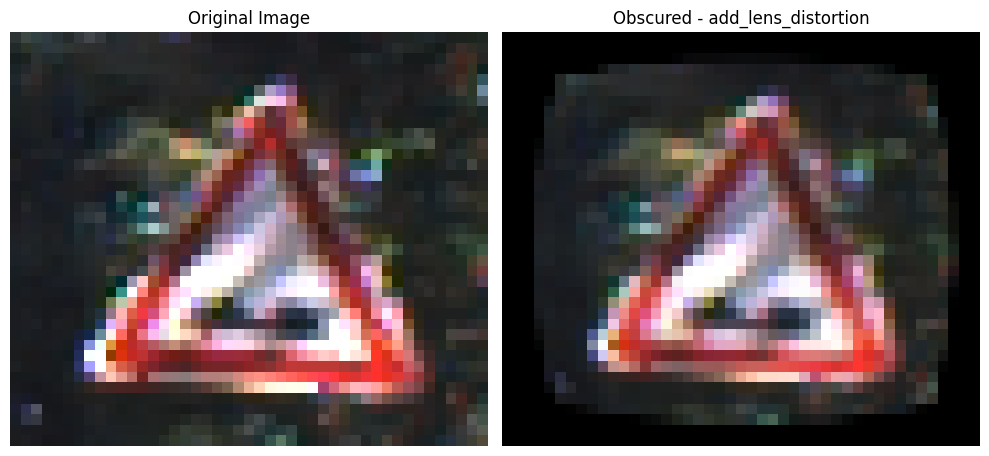

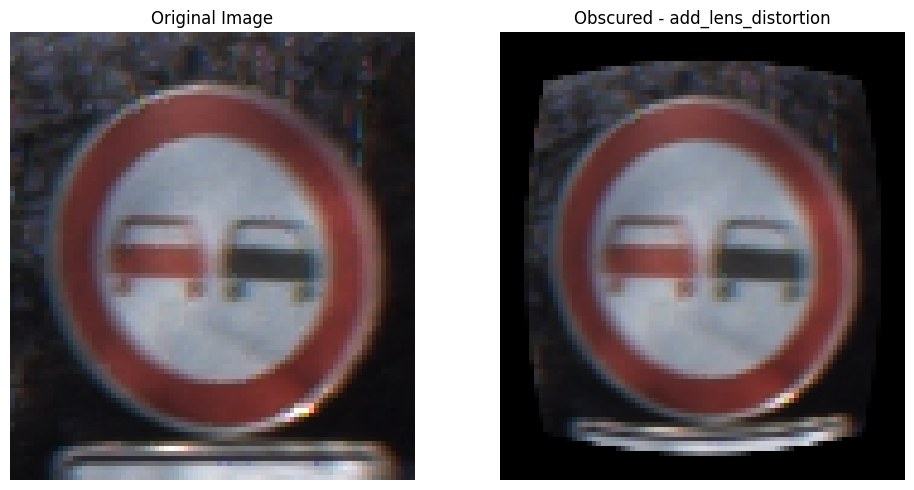

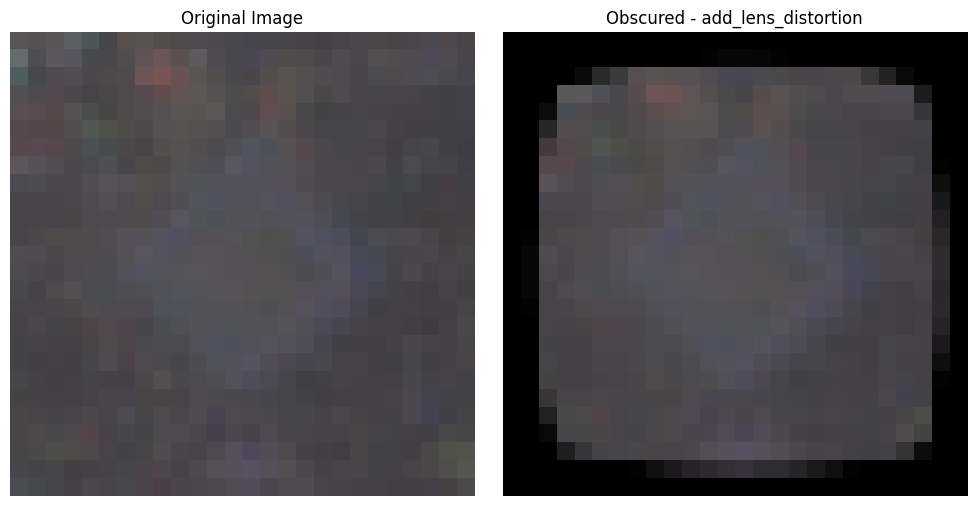

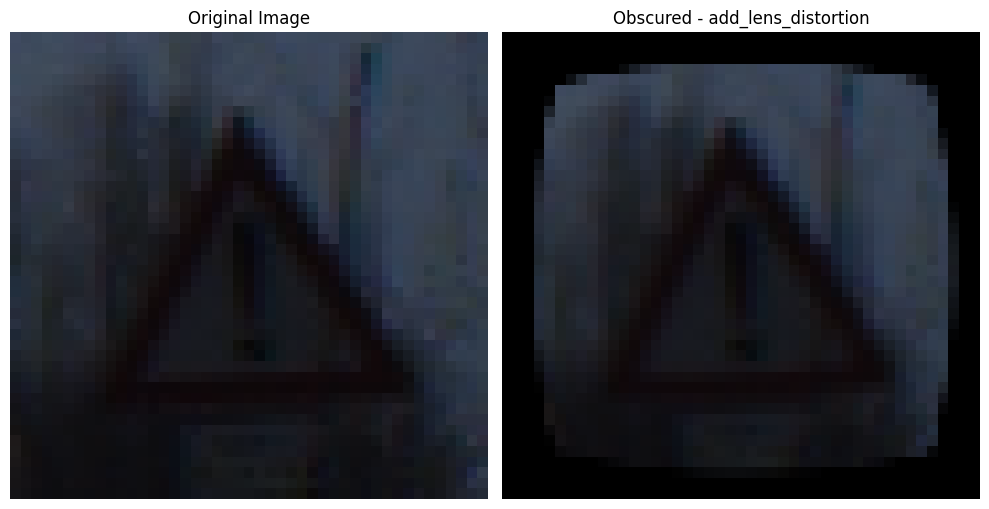

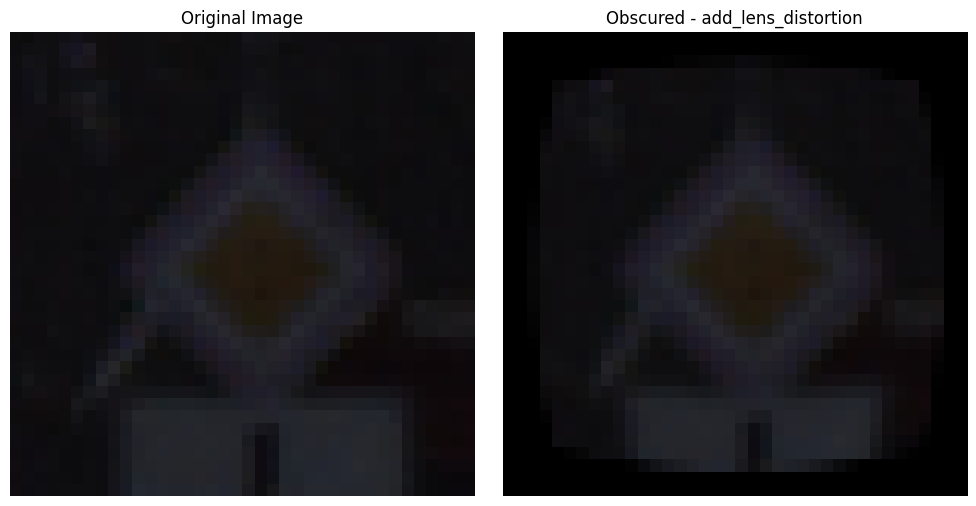

Applying obscuration function 10 out of 11...


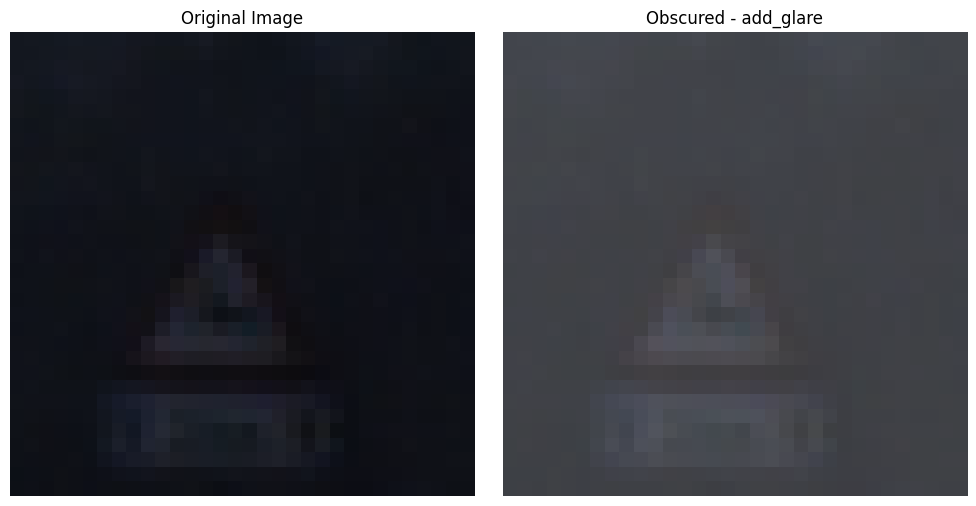

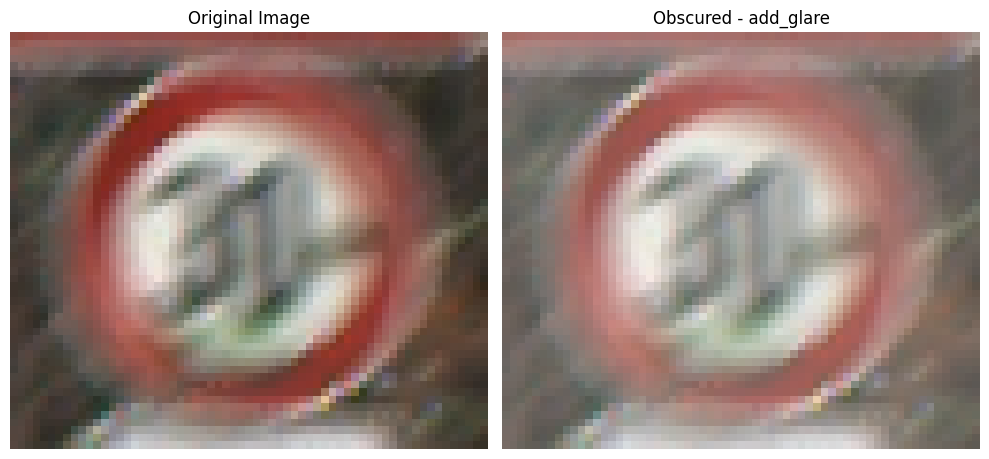

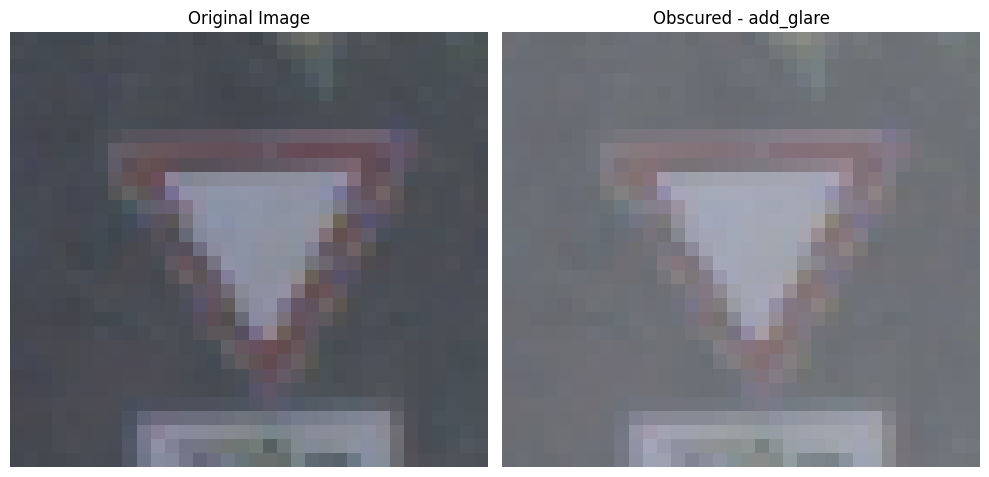

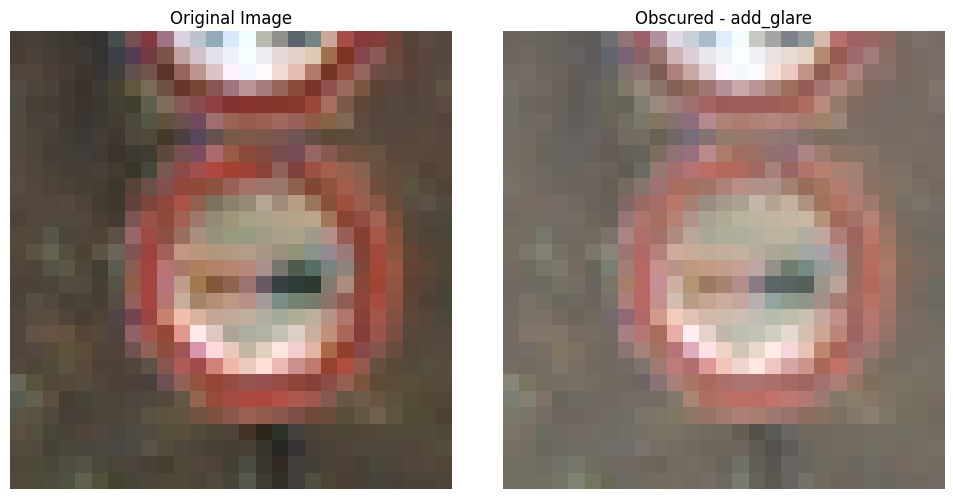

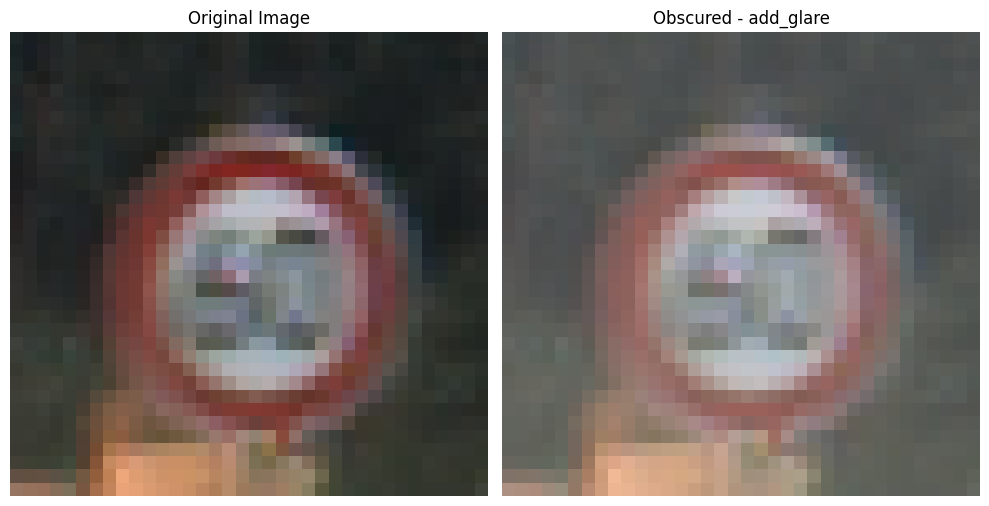

Applying obscuration function 11 out of 11...


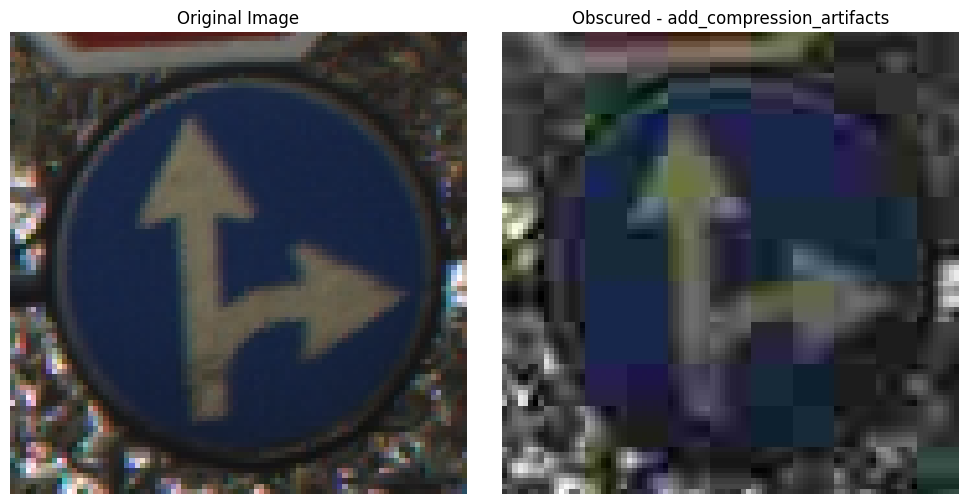

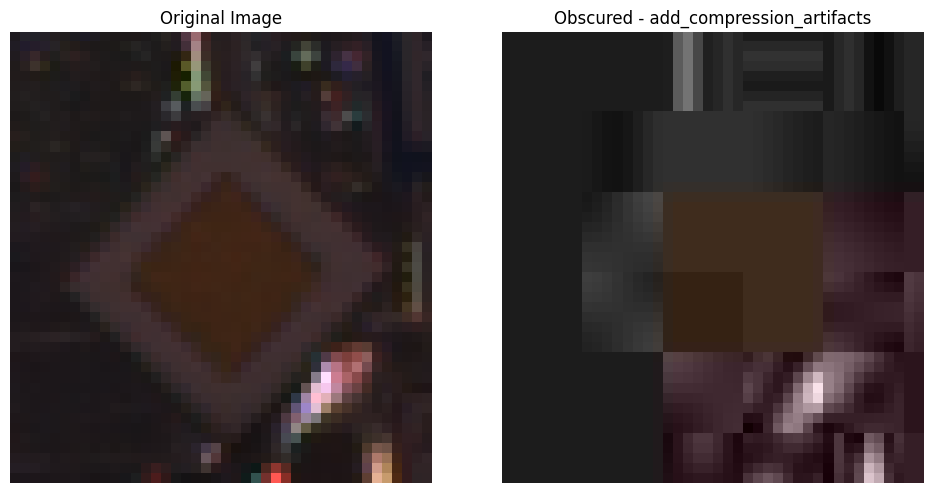

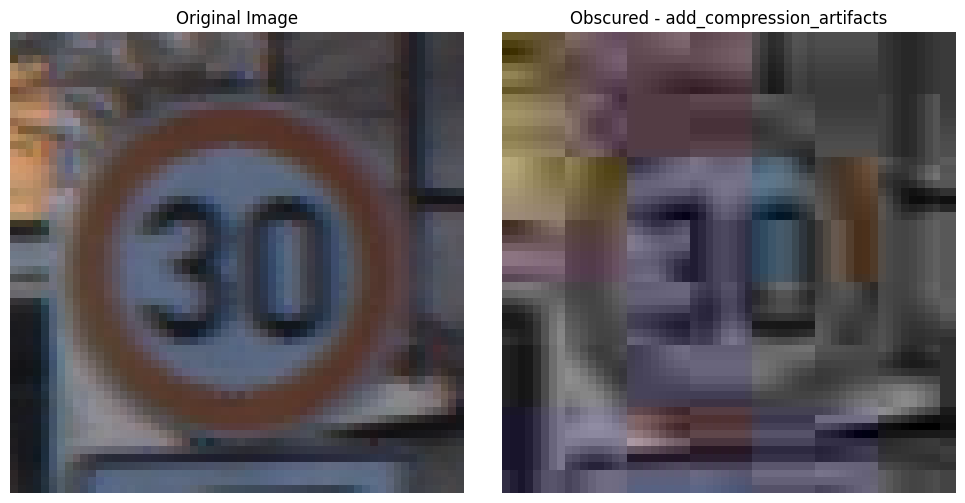

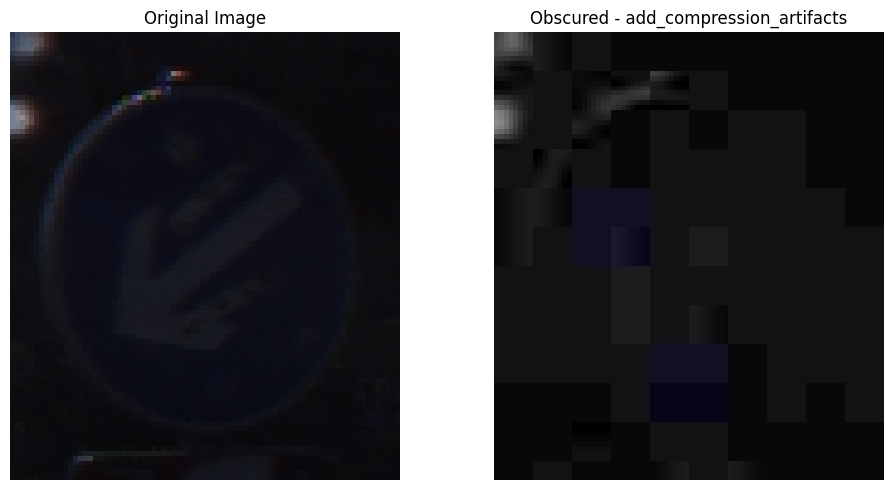

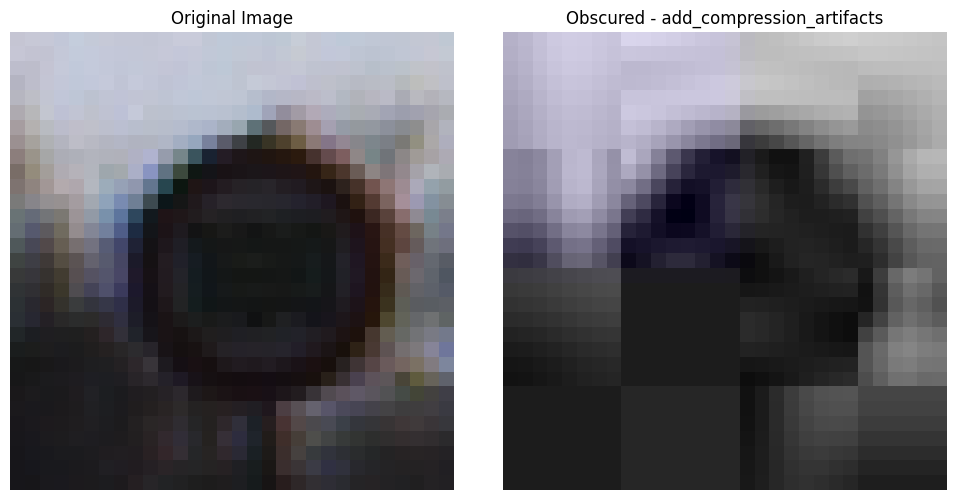

In [12]:
# Run the code

# Paths
train_input_dir = "Train"
train_output_dir = "Copied_Train"
obscured_train_output_dir = "Obscured_Train"
test_input_dir = "Test"
test_output_dir = "Copied_Test"
obscured_test_output_dir = "Obscured_Test"


# List of obscuration functions to apply
obscuration_functions = [
    add_blur, add_noise, add_whitening, add_fog,
    add_black_section, add_motion_blur, add_occlusion, add_low_light,
    add_lens_distortion, add_glare, add_compression_artifacts
]

# Copy original dataset to Copied_Train and Copied_Test
copy_original_dataset(train_input_dir, train_output_dir)
copy_original_dataset(test_input_dir, test_output_dir)

# Copy original dataset to Obscured_Train and Obscured_Test
copy_original_dataset(train_input_dir, obscured_train_output_dir)
copy_original_dataset(test_input_dir, obscured_test_output_dir)

# Apply obscured images with 3% obscuration per technique
select_and_obscure(train_input_dir, obscured_train_output_dir, obscuration_functions, obscuration_steps=len(obscuration_functions), percentage=3, is_train=True)
select_and_obscure(test_input_dir, obscured_test_output_dir, obscuration_functions, obscuration_steps=len(obscuration_functions), percentage=3, is_train=False)

Generating the Labels for Obscured Images

In [13]:
import pandas as pd
import os

# Define the function to create the `Obscured_Train.csv`
def create_obscured_csv(original_csv_path, obscured_dir, output_csv_path):
    """
    Create the `Obscured_Train.csv` file with ClassId and Path.
    
    Args:
        original_csv_path (str): Path to the original `Train.csv`.
        obscured_dir (str): Directory containing the obscured images.
        output_csv_path (str): Path to save the `Obscured_Train.csv`.
    """
    # Load the original Train.csv
    train_df = pd.read_csv(original_csv_path)
    
    # Filter to keep only ClassId and Path columns
    train_df = train_df[['ClassId', 'Path']]
    
    # Update the Path column to point to the obscured images directory
    train_df['Path'] = train_df['Path'].apply(lambda x: os.path.join(obscured_dir, os.path.basename(x)))
    
    # Check which obscured images exist
    obscured_paths = set(os.listdir(obscured_dir))
    train_df = train_df[train_df['Path'].apply(lambda x: os.path.basename(x) in obscured_paths)]
    
    # Save to Obscured_Train.csv
    train_df.to_csv(output_csv_path, index=False)
    print(f"Obscured_Train.csv created at {output_csv_path}")

# Example usage
original_csv_path = "Train.csv"  
obscured_dir = "Obscured_Train"  
output_csv_path = "Obscured_Train.csv"  
create_obscured_csv(original_csv_path, obscured_dir, output_csv_path)


Obscured_Train.csv created at Obscured_Train.csv


In [16]:
import pandas as pd
import os

# Define the function to create the `Obscured_Test.csv`
def create_obscured_csv(original_csv_path, obscured_dir, output_csv_path):
    """
    Create the `Obscured_Test.csv` file with ClassId and Path.
    
    Args:
        original_csv_path (str): Path to the original `Test.csv`.
        obscured_dir (str): Directory containing the obscured images.
        output_csv_path (str): Path to save the `Obscured_Test.csv`.
    """
    # Load the original Test.csv
    test_df = pd.read_csv(original_csv_path)
    
    # Filter to keep only ClassId and Path columns
    test_df = test_df[['ClassId', 'Path']]
    
    # Update the Path column to point to the obscured images directory
    test_df['Path'] = test_df['Path'].apply(lambda x: os.path.join(obscured_dir, os.path.basename(x)))
    
    # Check which obscured images exist
    obscured_paths = set(os.listdir(obscured_dir))
    test_df = test_df[test_df['Path'].apply(lambda x: os.path.basename(x) in obscured_paths)]
    
    # Save to Obscured_Train.csv
    test_df.to_csv(output_csv_path, index=False)
    print(f"Obscured_Test.csv created at {output_csv_path}")

# Example usage
original_csv_path = "Test.csv"  
obscured_dir = "Obscured_Test"  
output_csv_path = "Obscured_Test.csv"  
create_obscured_csv(original_csv_path, obscured_dir, output_csv_path)


Obscured_Test.csv created at Obscured_Test.csv


In [14]:
import pandas as pd
import os

# Load the Train.csv into a pandas DataFrame
train_df = pd.read_csv("Train.csv")

# Function to modify the Path
def modify_path(path):
    # Replace 'Train' with 'Copied_Train' and remove the middle folder
    path_parts = path.split(os.sep)  # Split by the OS-specific separator
    new_path = os.path.join("Copied_Train", path_parts[-1])  # Join the last part of the path with 'Copied_Train'
    return new_path

# Apply the modify_path function to the 'Path' column
train_df['Path'] = train_df['Path'].apply(modify_path)

# Save the new DataFrame as Copied_Train.csv
train_df.to_csv("Copied_Train.csv", index=False)

print("Copied_Train.csv has been created.")

Copied_Train.csv has been created.


In [15]:
import pandas as pd
import os

# Load the Test.csv into a pandas DataFrame
test_df = pd.read_csv("Test.csv")

# Function to modify the Path
def modify_path(path):
    # Replace 'Test' with 'Copied_Test' and remove the middle folder
    path_parts = path.split(os.sep)  # Split by the OS-specific separator
    new_path = os.path.join("Copied_Test", path_parts[-1])  # Join the last part of the path with 'Copied_Test'
    return new_path

# Apply the modify_path function to the 'Path' column
test_df['Path'] = test_df['Path'].apply(modify_path)

# Save the new DataFrame as Copied_Test.csv
test_df.to_csv("Copied_Test.csv", index=False)

print("Copied_Test.csv has been created.")

Copied_Test.csv has been created.
